In [11]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

mpl.rc('figure', figsize=(8, 5))
mpl.rc('figure', dpi=300)

import warnings
warnings.simplefilter("ignore")

# Table of Contents
>## 1. Activation Function
* 1.1. Vanishing Gradient Problem
* 1.2. Vanishing Gradient Problem - Visualization
* 1.3. $\text{tanh}(a)$
* 1.4. Rectified Linear Unit (ReLU)
* 1.5. `keras` - `activation`

>## 2. Cost Function
* 2.1. Cross-Entropy
* 2.2. `keras` - `loss`

>## 3. Weight Initialization
* 3.1. Glorot Initialization
* 3.2. LeCun Initialization
* 3.3. `keras` - `kernel_initializer`

>## 4. Optimization Algorithm


>## 5. Regularization
* 5.1. Overfitting
* 5.2. L1 & L2 Regularization
* 5.3. `keras` - `kernel_regularizer`
* 5.4. Dropout Regularization
* 5.5. `keras` - `Dropout`

>## 6. Softmax
* 6.1. `keras` - `activation='softmax'`

>## 7. Batch Normalization
* 7.1. `keras` - `BatchNormalization`

오차(목적) 함수 개선: cross-entropy cost function
가중치 초기값: weight initialization
정규화: regularization
Softmax 출력
Batch Normalization

# 1. Activation Function

## 1.1. Vanishing Gradient Problem
* **No. of Hidden Layers $\uparrow$ $\rightarrow$ Performance $\downarrow$**
* **WHY?** 
>* As the error backpropagate,
>* The gradient of the activation fn. is multiplied
>* This value is close to zero $\rightarrow$ gradient vanishes

## 1.2. Vanishing Gradient Problem - Visualization

### Gradient of the Sigmoid Function

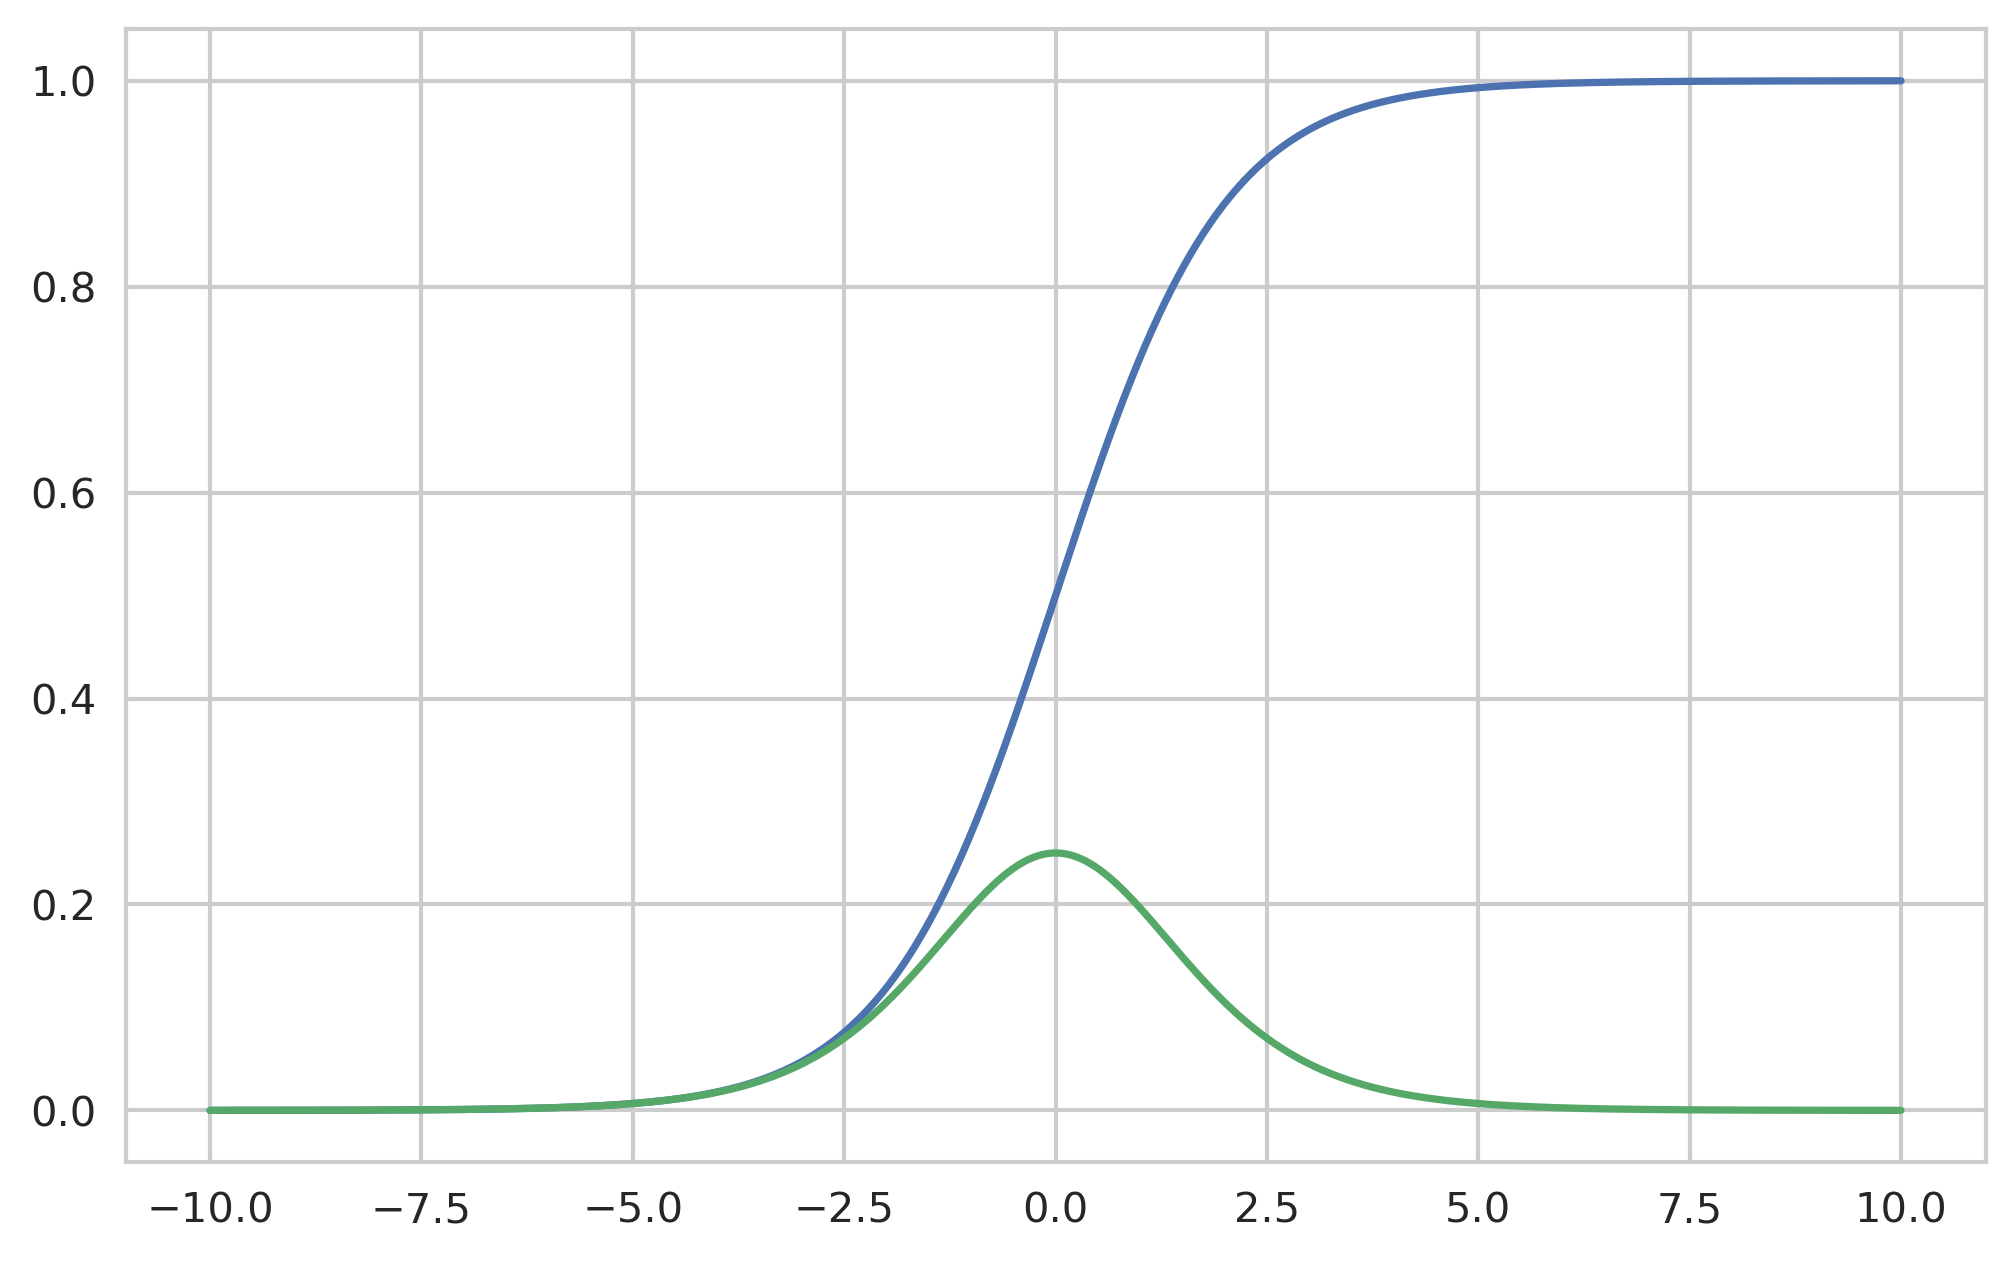

In [3]:
sigmoid = lambda x: 1/(1+np.exp(-x))
sigmoid_prime = lambda x: sigmoid(x)*(1-sigmoid(x))
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, sigmoid(xx))
plt.plot(xx, sigmoid_prime(xx))
plt.show()

### Compare 4 Models with 1~4 Hidden Layers

In [2]:
from keras.datasets import mnist
from keras.utils import np_utils

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

X_train = X_train0.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test0.reshape(10000, 784).astype('float32') / 255.0
Y_train = np_utils.to_categorical(y_train0, 10)
Y_test = np_utils.to_categorical(y_test0, 10)

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

In [4]:
model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation="sigmoid"))
model1.add(Dense(10, activation="sigmoid"))
model1.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [5]:
model2 = Sequential()
model2.add(Dense(15, input_dim=784, activation="sigmoid"))
model2.add(Dense(15, activation="sigmoid"))
model2.add(Dense(10, activation="sigmoid"))
model2.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [6]:
model3 = Sequential()
model3.add(Dense(15, input_dim=784, activation="sigmoid"))
model3.add(Dense(15, activation="sigmoid"))
model3.add(Dense(15, activation="sigmoid"))
model3.add(Dense(10, activation="sigmoid"))
model3.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [7]:
model4 = Sequential()
model4.add(Dense(15, input_dim=784, activation="sigmoid"))
model4.add(Dense(15, activation="sigmoid"))
model4.add(Dense(15, activation="sigmoid"))
model4.add(Dense(15, activation="sigmoid"))
model4.add(Dense(10, activation="sigmoid"))
model4.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [8]:
from keras.callbacks import Callback

class WeightHistory(Callback):
    
    def __init__(self, model, num_epoch):
        super().__init__()
        self.model = model
        self.num_hidden = len(model.layers) - 1
        self.weight_old = [self.model.layers[i].get_weights()[0] for i in range(self.num_hidden)]
        self.weight = [0.0 for i in range(self.num_hidden)]
        self.weight_change = np.zeros((self.num_hidden, num_epoch))
        
    def on_epoch_end(self, epoch, logs={}):
        for i in range(self.num_hidden):
            self.weight[i] = self.model.layers[i].get_weights()[0]
            self.weight_change[i, epoch] = np.abs((self.weight[i] - self.weight_old[i]).mean())
            self.weight_old[i] = self.weight[i]
            

In [9]:
num_epoch = 500

In [10]:
%%time
callback1 = WeightHistory(model1, num_epoch)
hist1 = model1.fit(X_train, Y_train, epochs=num_epoch, batch_size=100, callbacks=[callback1], verbose=0)

CPU times: user 40min 55s, sys: 1h 1min 9s, total: 1h 42min 5s
Wall time: 34min 10s


### Result - 1 Hidden Layer

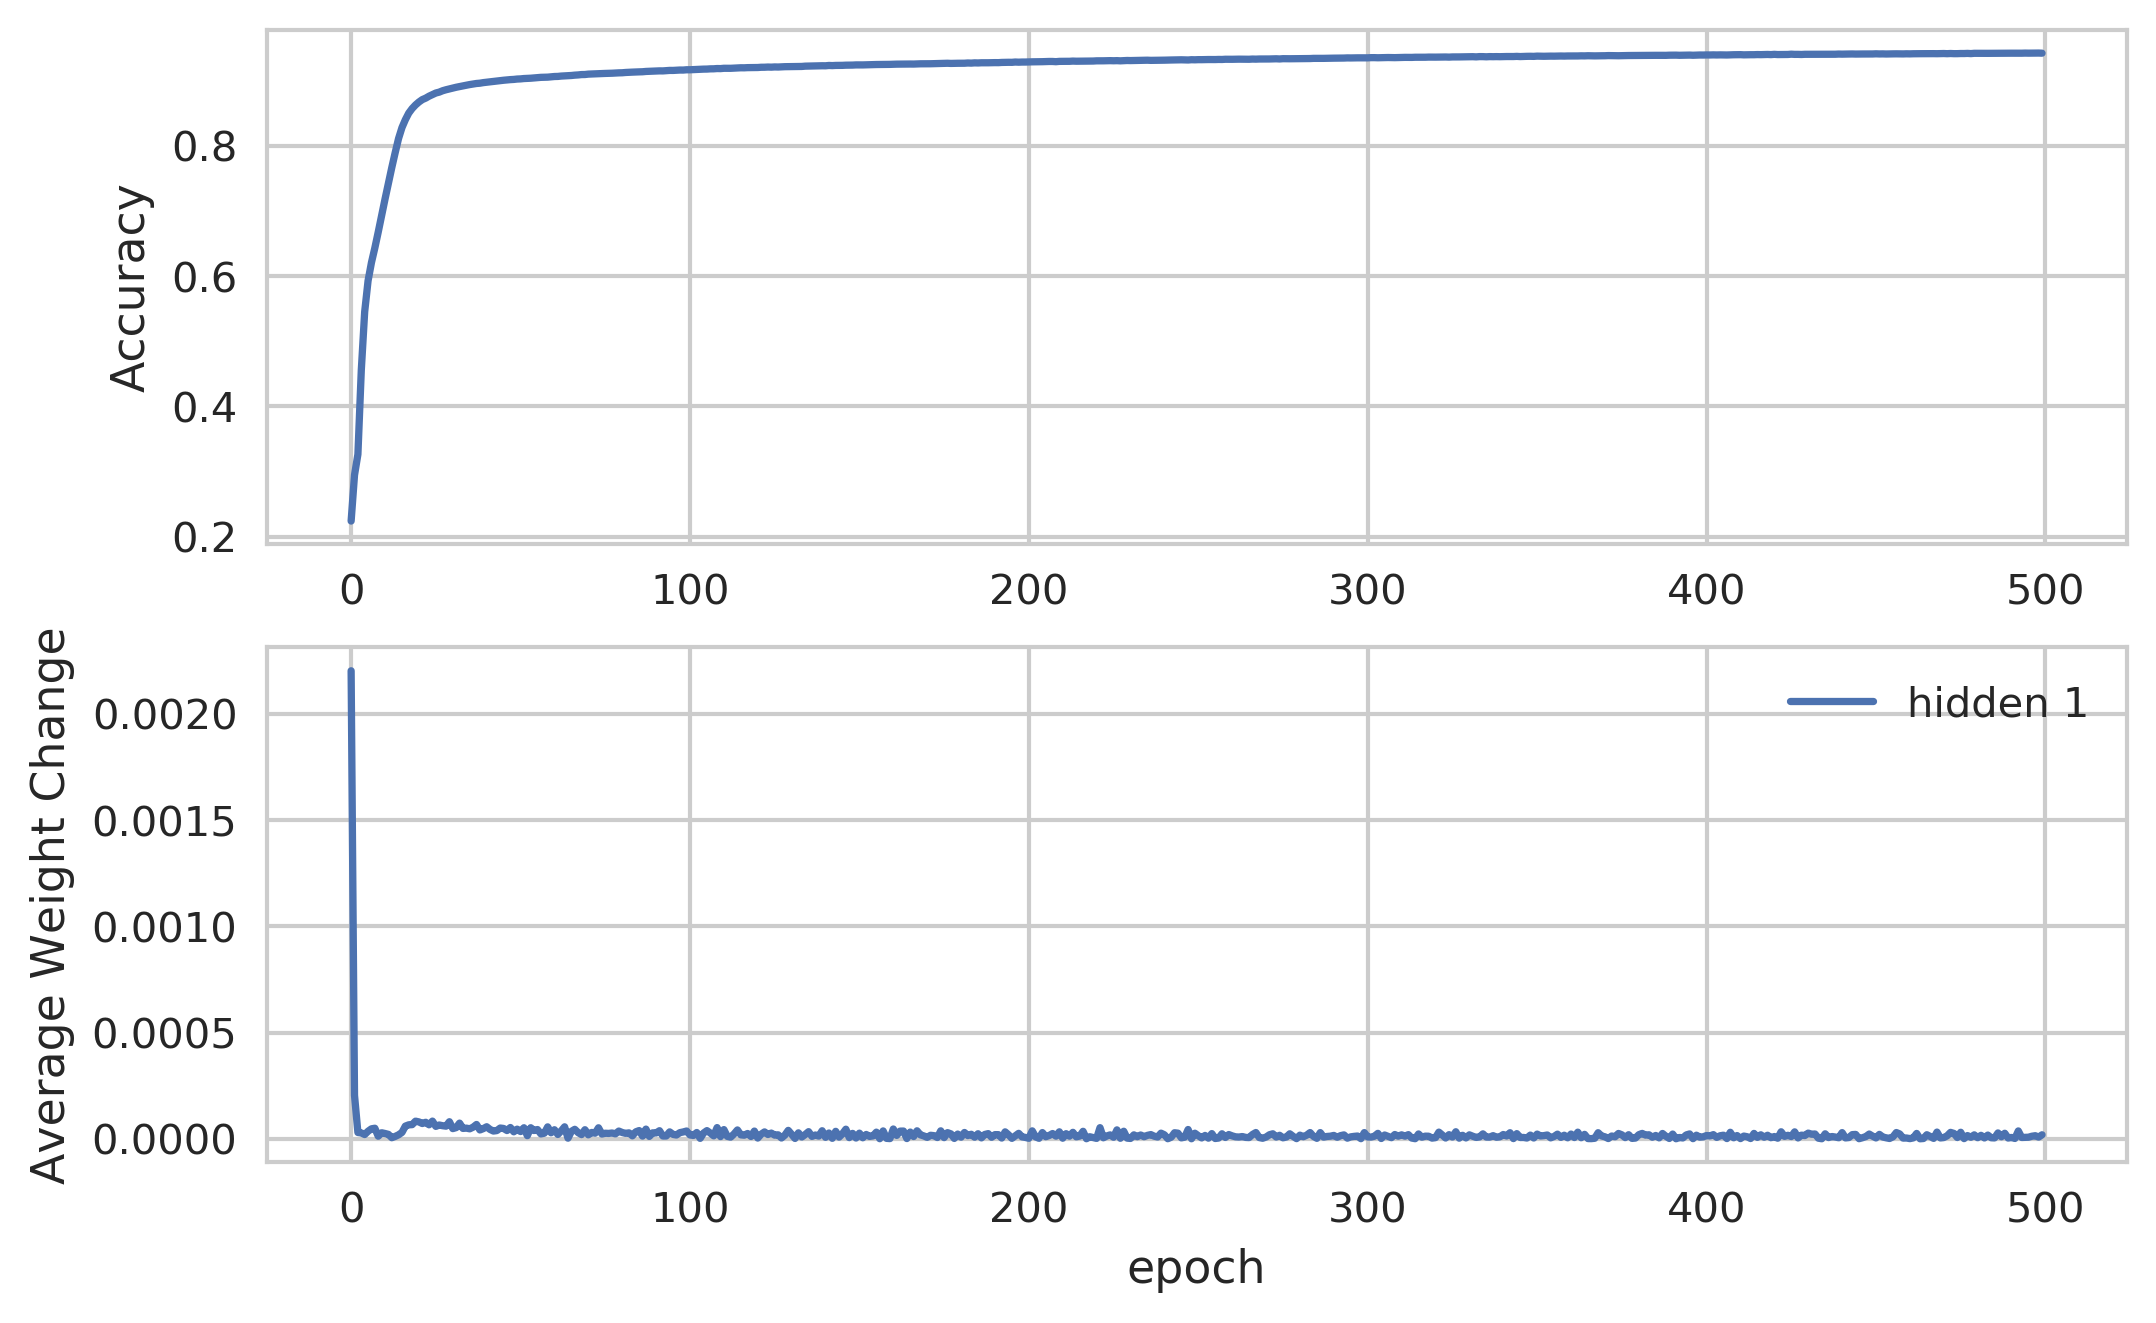

In [82]:
plt.subplot(2, 1, 1)
plt.plot(hist1.history['acc'])
plt.ylabel("Accuracy")
plt.subplot(2, 1, 2)
plt.plot(callback1.weight_change[0], label="hidden 1")
plt.xlabel("epoch")
plt.ylabel("Average Weight Change")
plt.legend()
plt.show()

In [99]:
hist1.history['acc'][-1]

0.942866667509079

In [83]:
%%time
callback2 = WeightHistory(model2, num_epoch)
hist2 = model2.fit(X_train, Y_train, epochs=num_epoch, batch_size=100, callbacks=[callback2], verbose=0)

CPU times: user 28min 35s, sys: 2min 42s, total: 31min 17s
Wall time: 14min 57s


### Result - 2 Hidden Layers

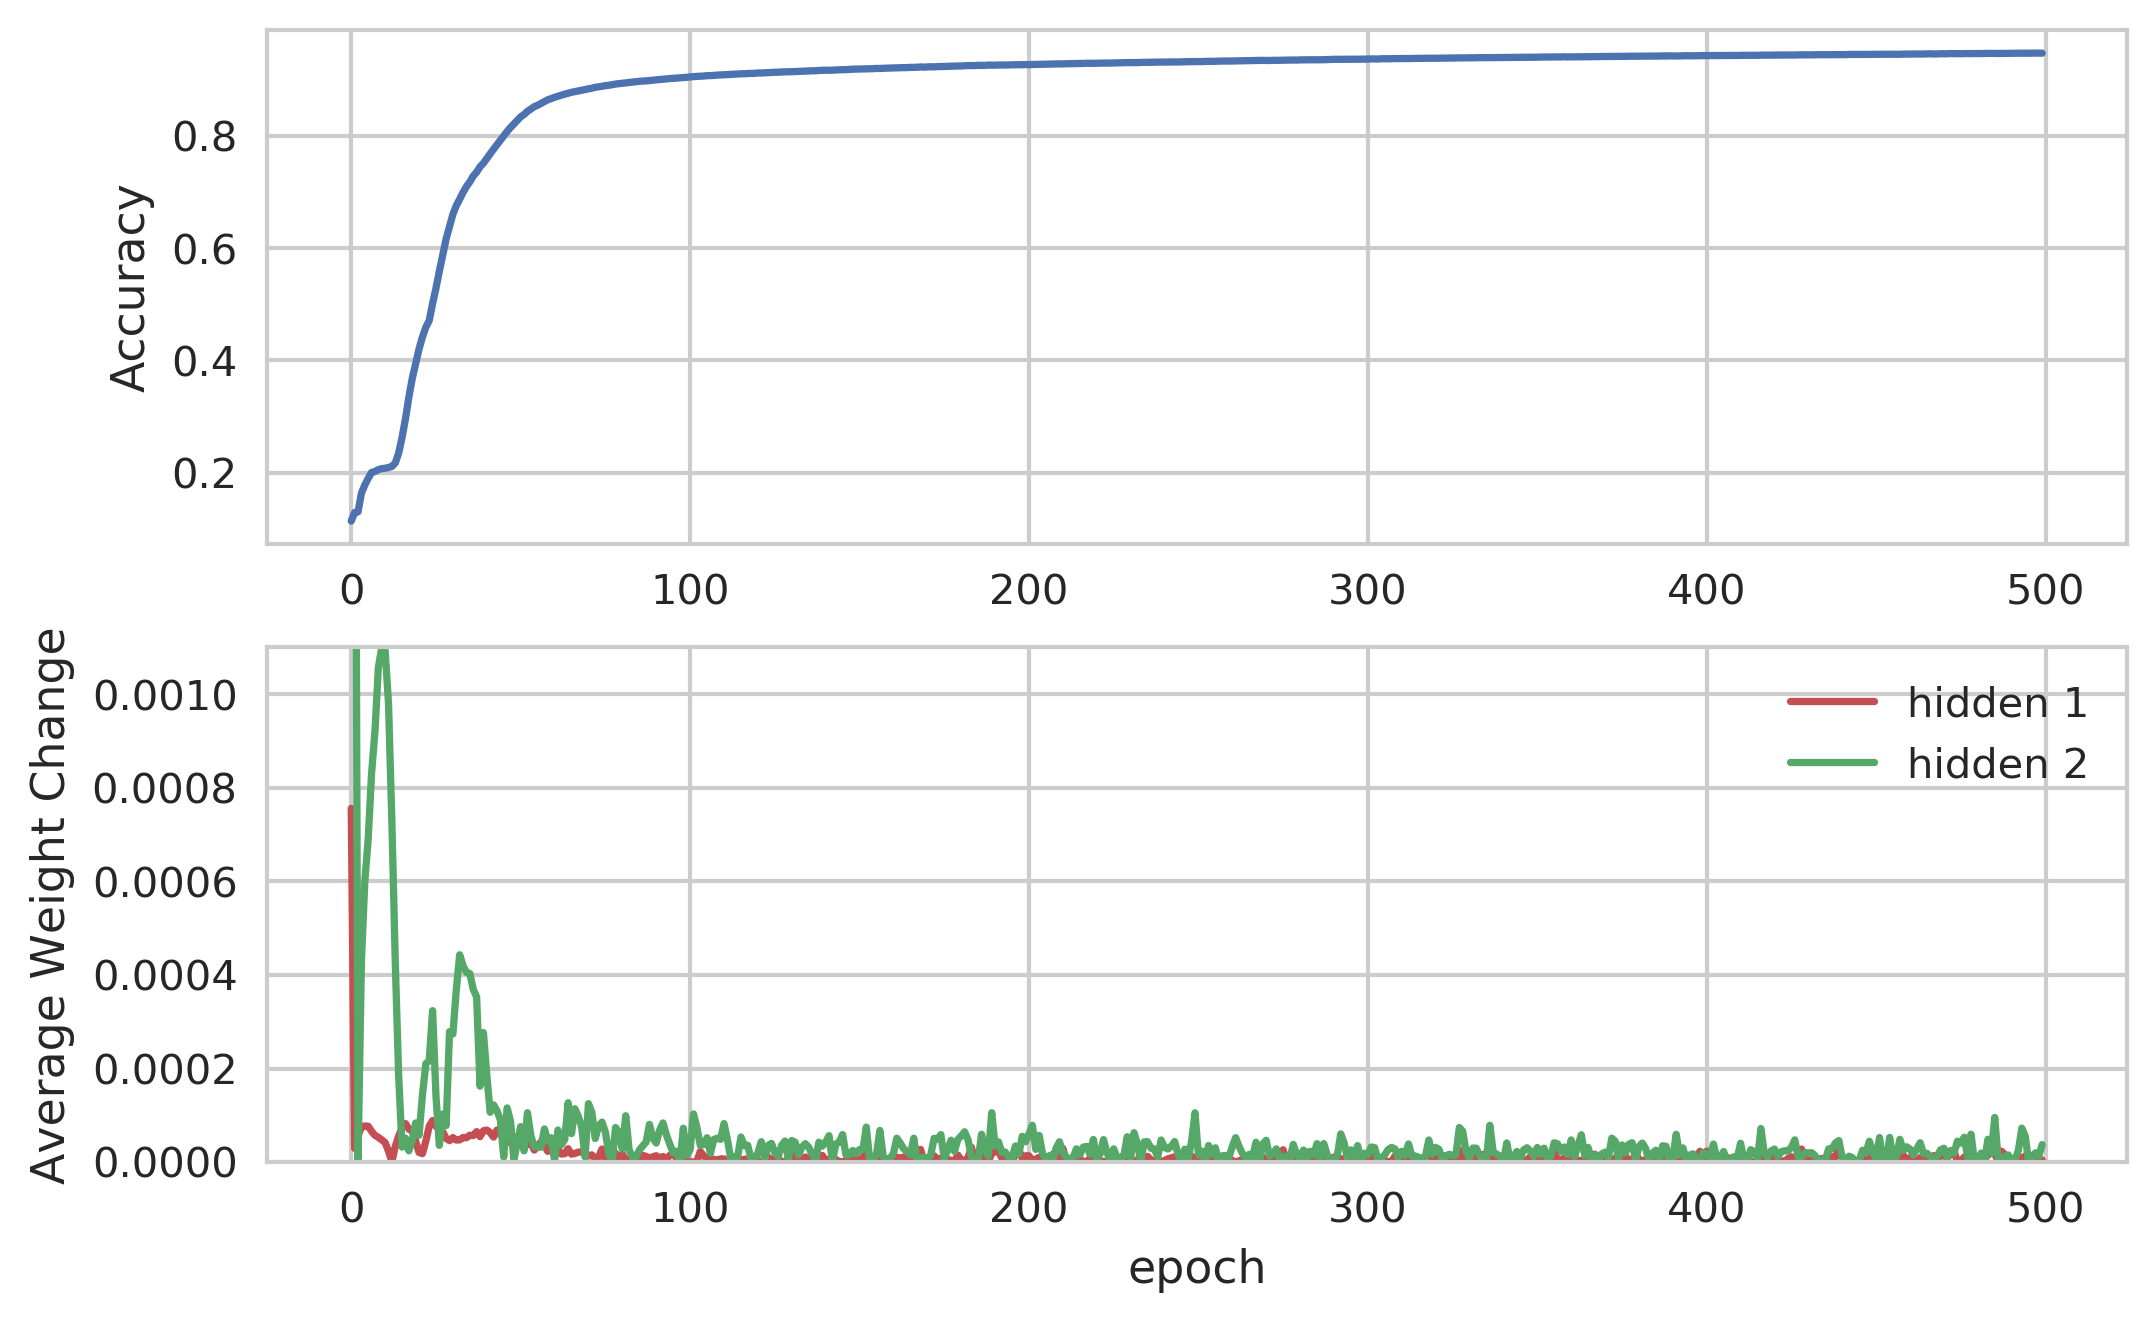

In [84]:
plt.subplot(2, 1, 1)
plt.plot(hist2.history['acc'])
plt.ylabel("Accuracy")
plt.subplot(2, 1, 2)
plt.plot(callback2.weight_change[0], 'r', label="hidden 1")
plt.plot(callback2.weight_change[1], 'g', label="hidden 2")
plt.xlabel("epoch")
plt.ylabel("Average Weight Change")
plt.ylim(0, np.max(callback2.weight_change[-1][5:]))
plt.legend()
plt.show()

In [98]:
hist2.history['acc'][-1]

0.9475666667024295

In [85]:
%%time
callback3 = WeightHistory(model3, num_epoch)
hist3 = model3.fit(X_train, Y_train, epochs=num_epoch, batch_size=100, callbacks=[callback3], verbose=0)

CPU times: user 29min 59s, sys: 2min 56s, total: 32min 55s
Wall time: 16min 17s


### Result - 3 Hidden Layers

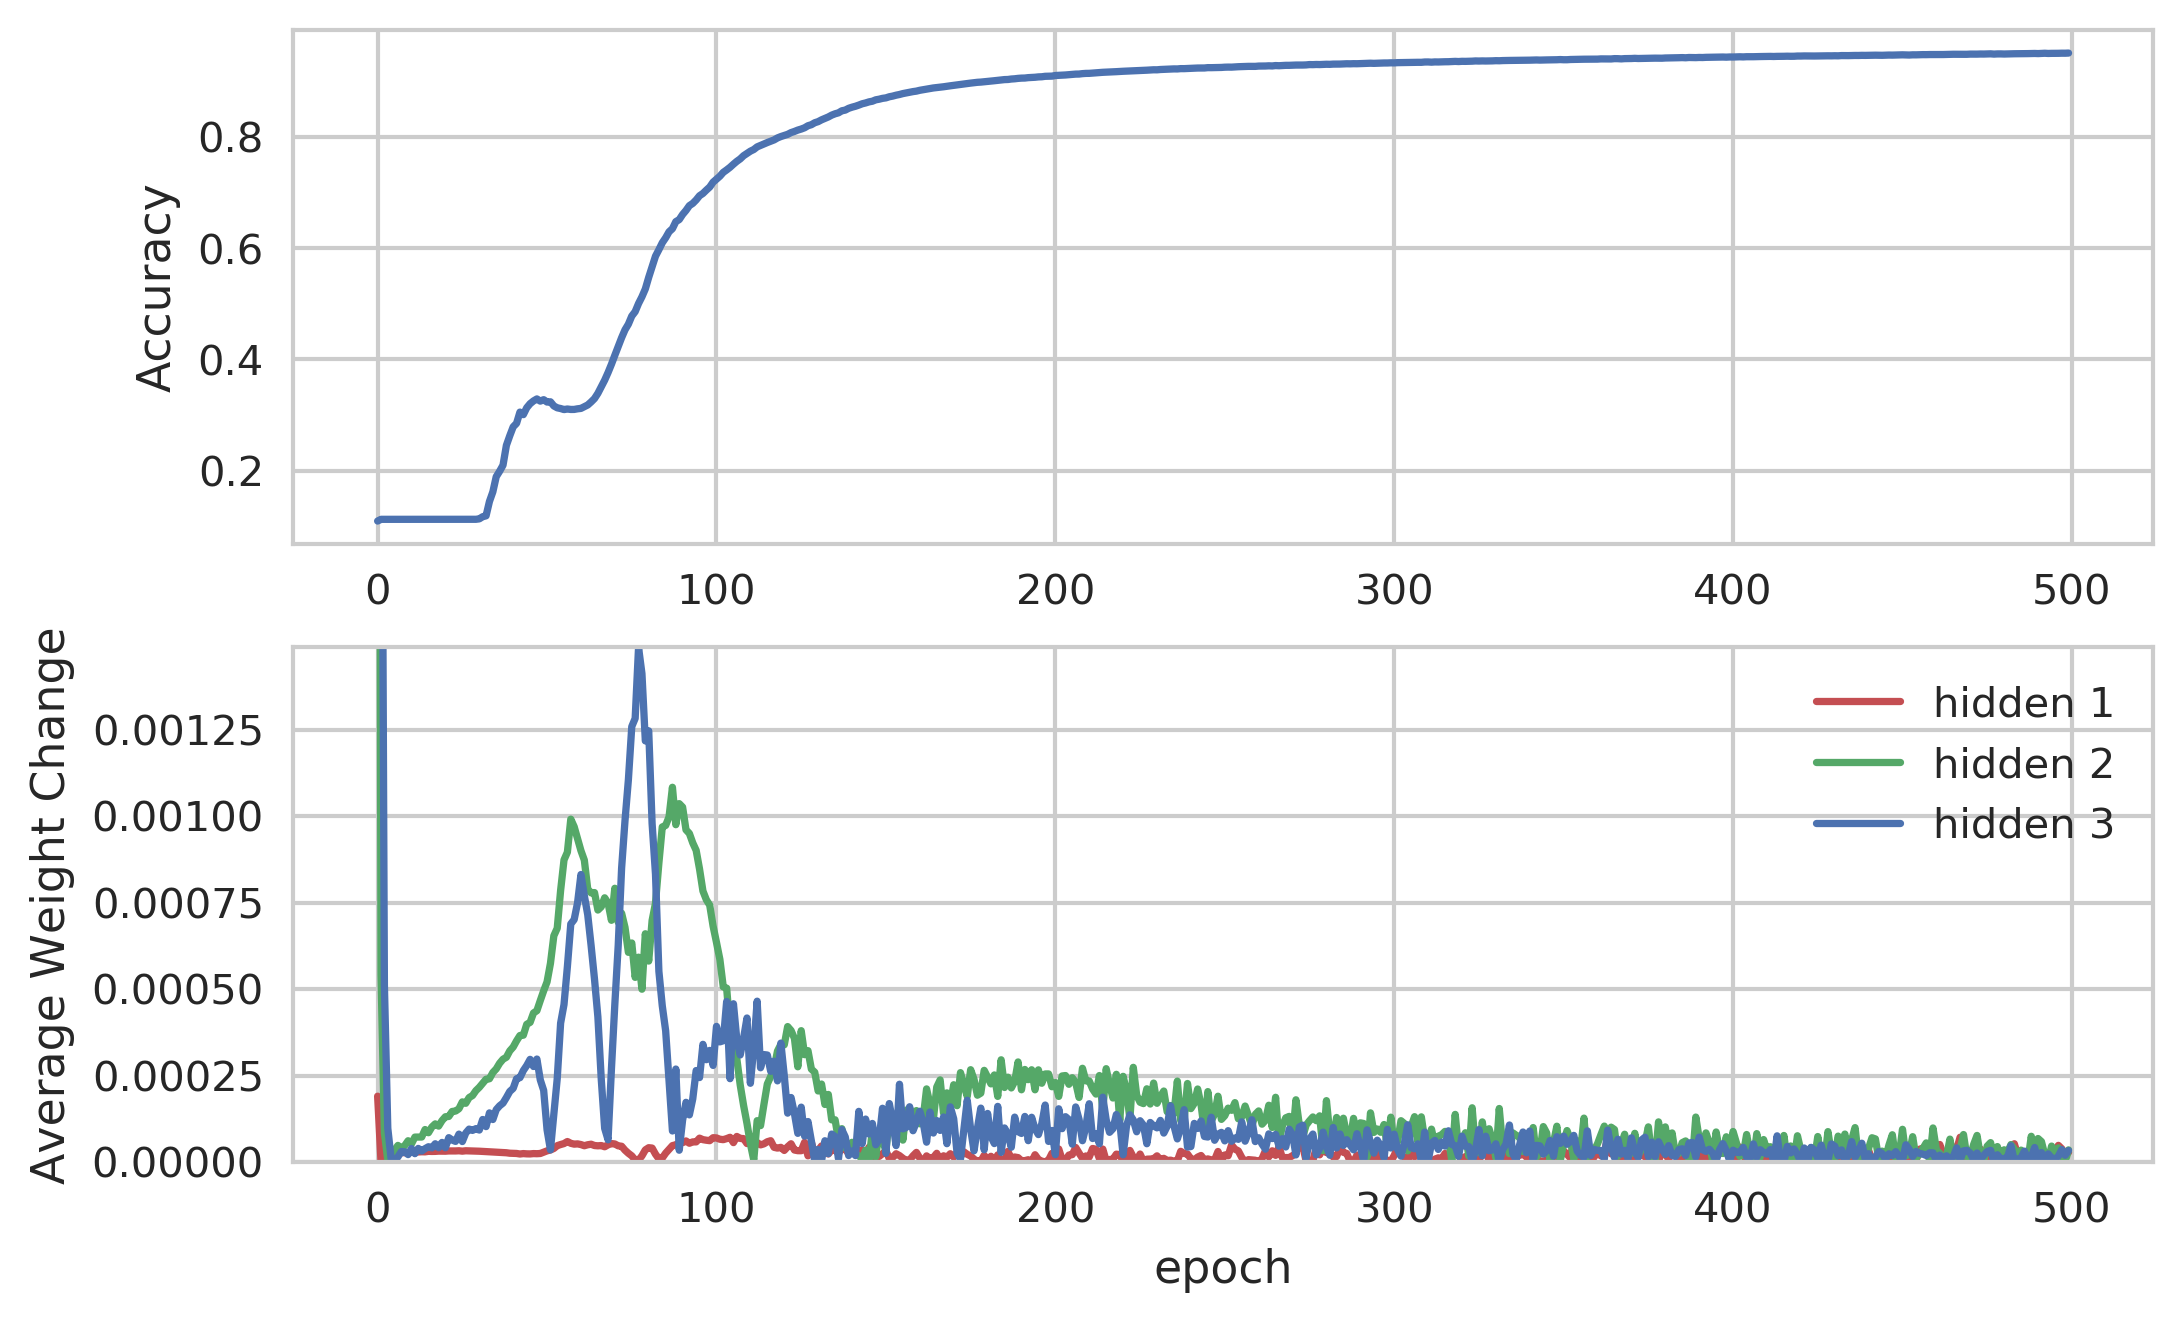

In [86]:
plt.subplot(2, 1, 1)
plt.plot(hist3.history['acc'])
plt.ylabel("Accuracy")
plt.subplot(2, 1, 2)
plt.plot(callback3.weight_change[0], 'r', label="hidden 1")
plt.plot(callback3.weight_change[1], 'g', label="hidden 2")
plt.plot(callback3.weight_change[2], 'b', label="hidden 3")
plt.xlabel("epoch")
plt.ylabel("Average Weight Change")
plt.ylim(0, np.max(callback3.weight_change[-1][5:]))
plt.legend()
plt.show()

In [97]:
hist3.history['acc'][-1]

0.9509166686733563

In [87]:
%%time
callback4 = WeightHistory(model4, num_epoch)
hist4 = model4.fit(X_train, Y_train, epochs=num_epoch, batch_size=100, callbacks=[callback4], verbose=0)

CPU times: user 31min 11s, sys: 3min 10s, total: 34min 21s
Wall time: 17min 26s


### Result - 4 Hidden Layers

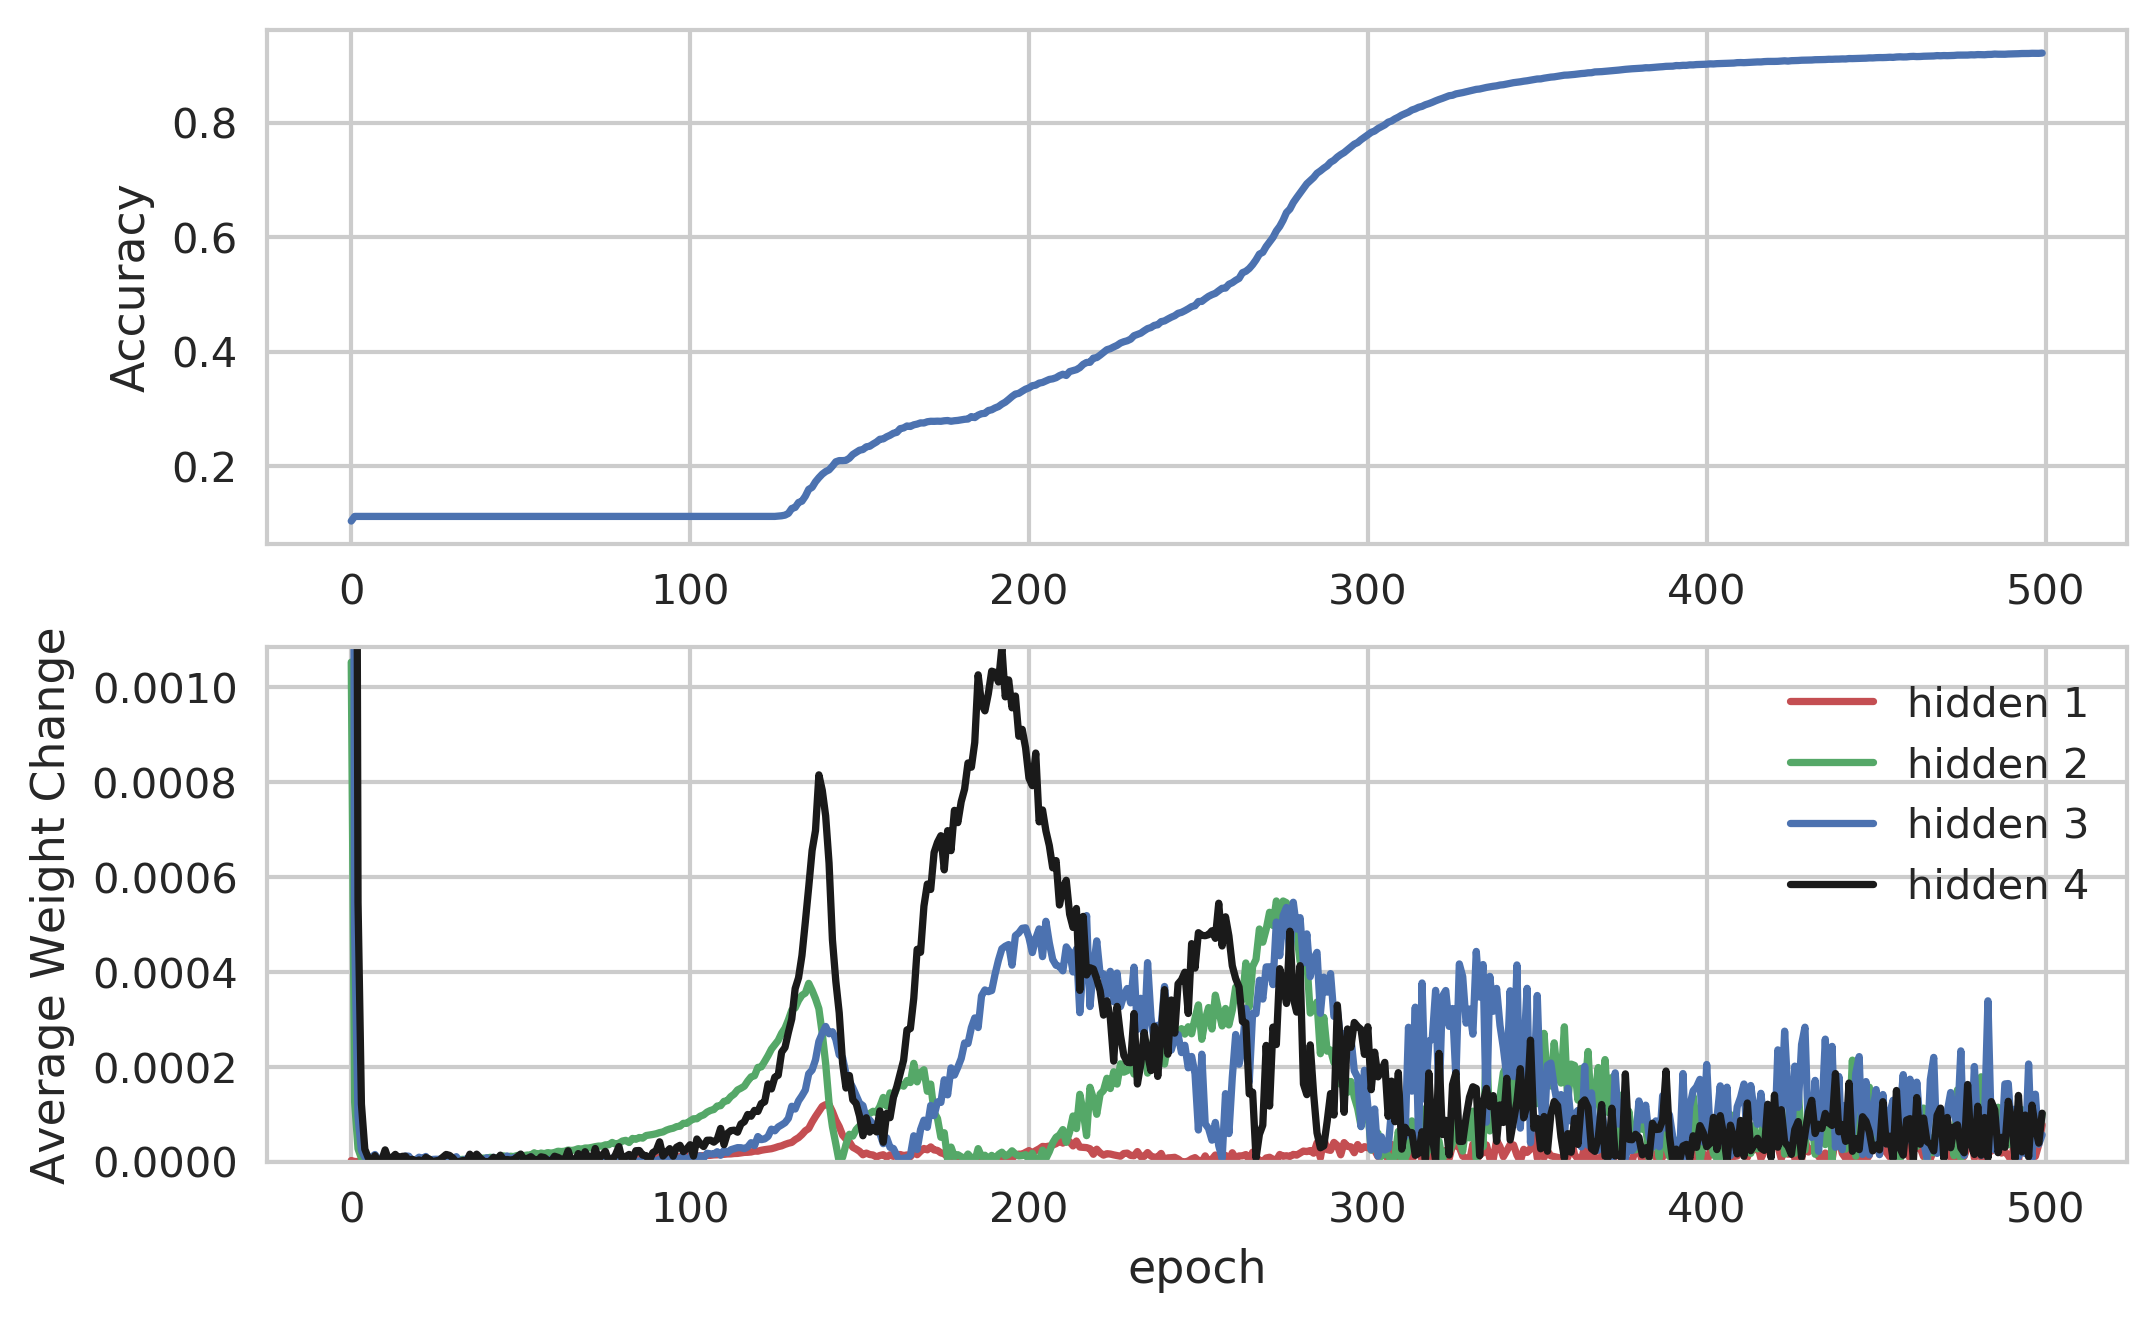

In [93]:
plt.subplot(2, 1, 1)
plt.plot(hist4.history['acc'])
plt.ylabel("Accuracy")
plt.subplot(2, 1, 2)
plt.plot(callback4.weight_change[0], 'r', label="hidden 1")
plt.plot(callback4.weight_change[1], 'g', label="hidden 2")
plt.plot(callback4.weight_change[2], 'b', label="hidden 3")
plt.plot(callback4.weight_change[3], 'k', label="hidden 4")
plt.xlabel("epoch")
plt.ylabel("Average Weight Change")
plt.ylim(0, np.max(callback4.weight_change[-1][5:]))
plt.legend()
plt.show()

In [96]:
hist4.history['acc'][-1]

0.92180000325044

## 1.3. $\text{tanh}(a)$
* Maximum Gradient: $1$ *(4 times bigger than that of Sigmoid)*

>$$
\begin{eqnarray}
  \tanh(a) \equiv \frac{e^a-e^{-a}}{e^a+e^{-a}} = 2\sigma(2a) - 1
\end{eqnarray}
$$

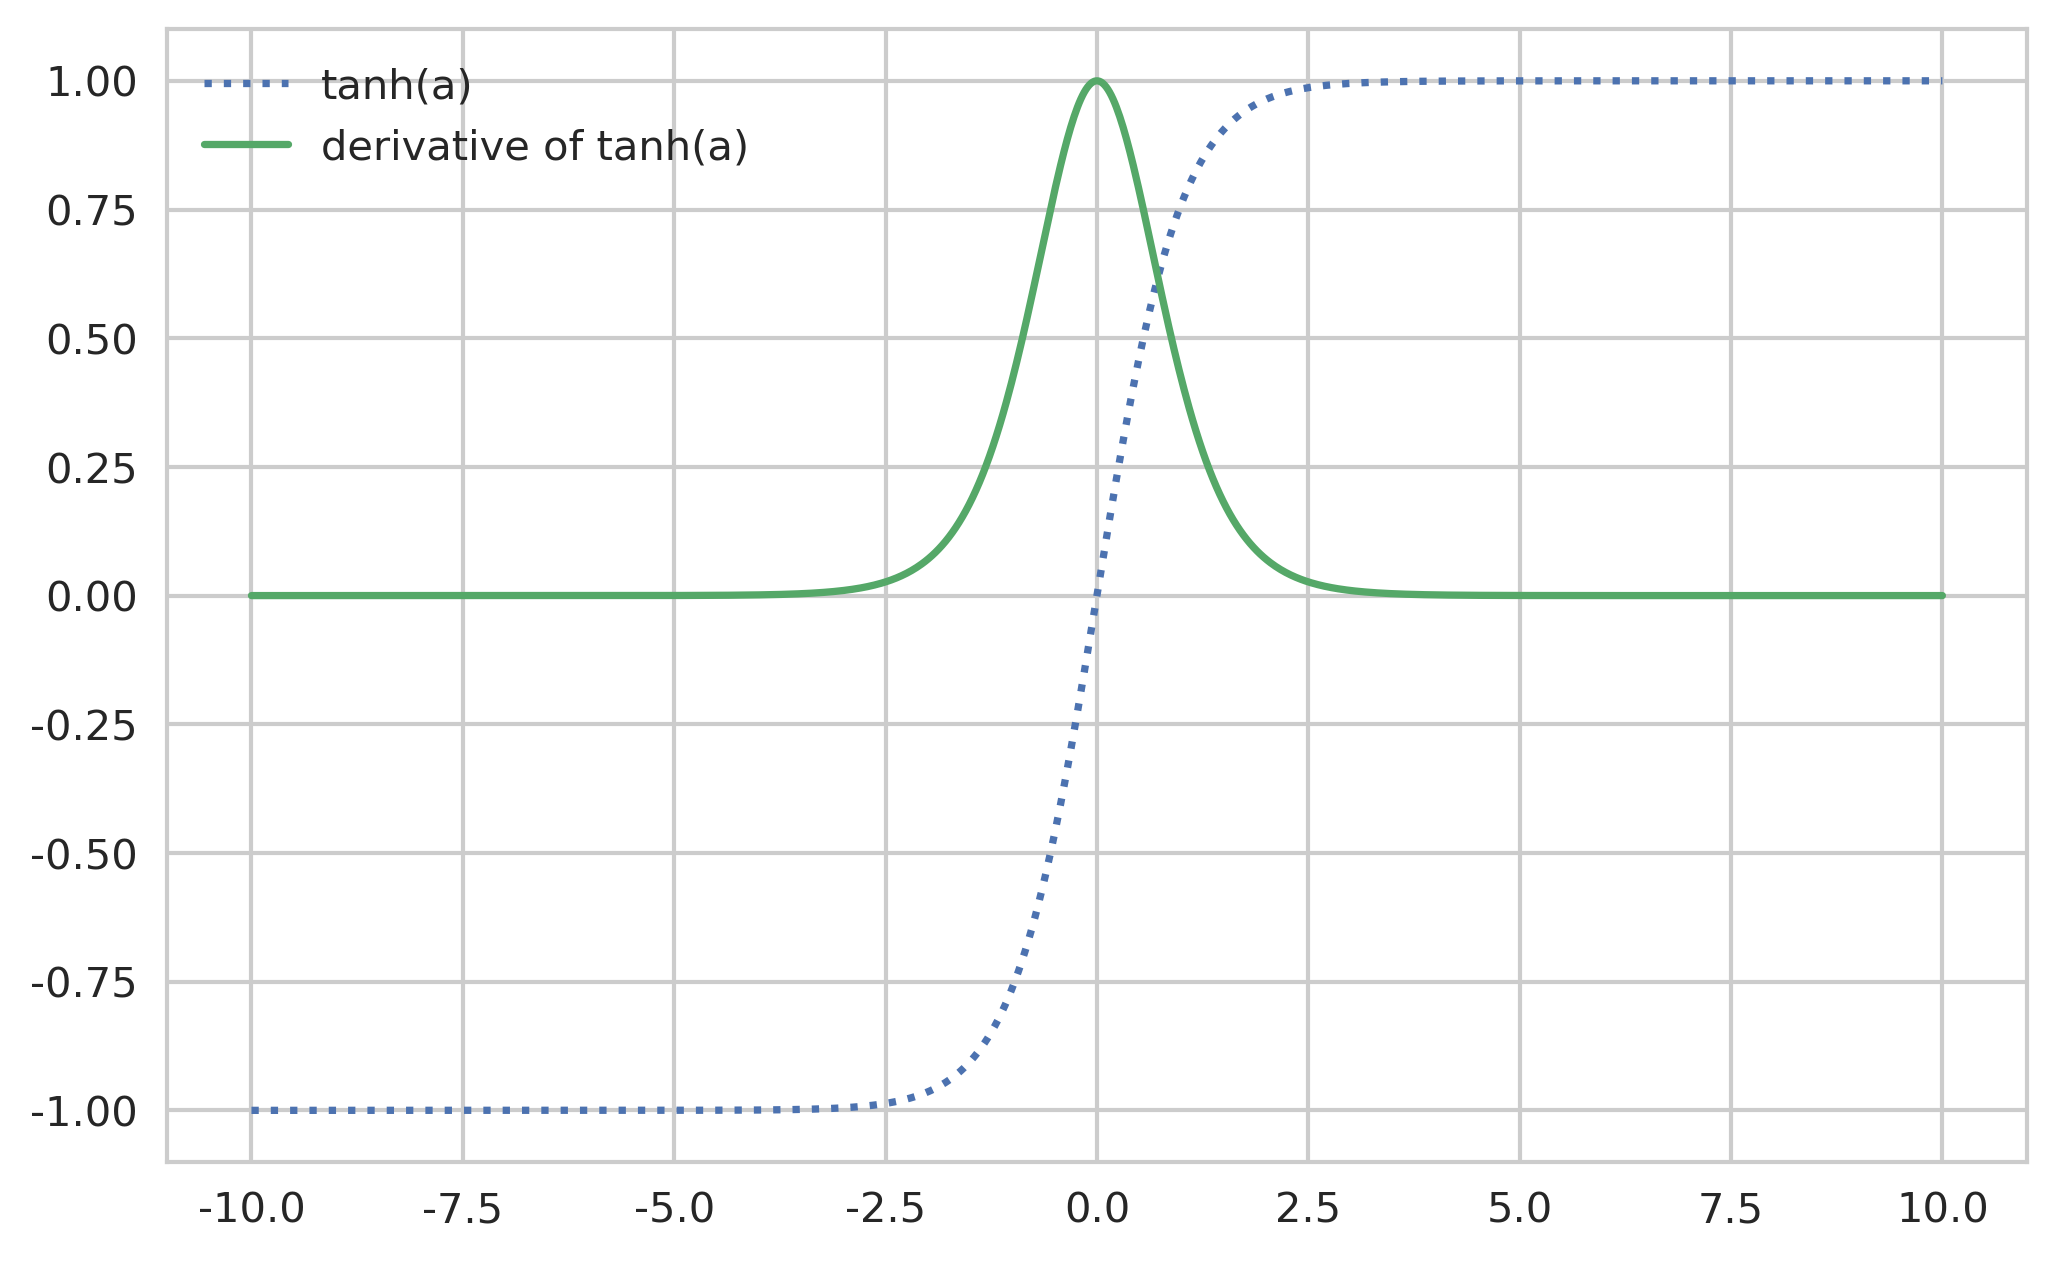

In [25]:
tanh = lambda x: np.tanh(x)
tanh_prime = lambda x: 1 - np.tanh(x) ** 2
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, tanh(xx), 'b:', label="tanh(a)")
plt.plot(xx, tanh_prime(xx), 'g-', label="derivative of tanh(a)")
plt.legend()
plt.show()

## 1.4. Rectified Linear Unit (ReLu)

* Solves vanishing gradient problem
* Widely used for NN with large no. of hidden layers
* **ReLU**

>$$
\begin{eqnarray}
  \max(0, a)
\end{eqnarray}
$$

* **Leaky ReLU** (Non-zero gradient for $a<0$

>$$
\begin{eqnarray}
  \max(\alpha a, a) \;\; (0 < \alpha < 1)
\end{eqnarray}
$$


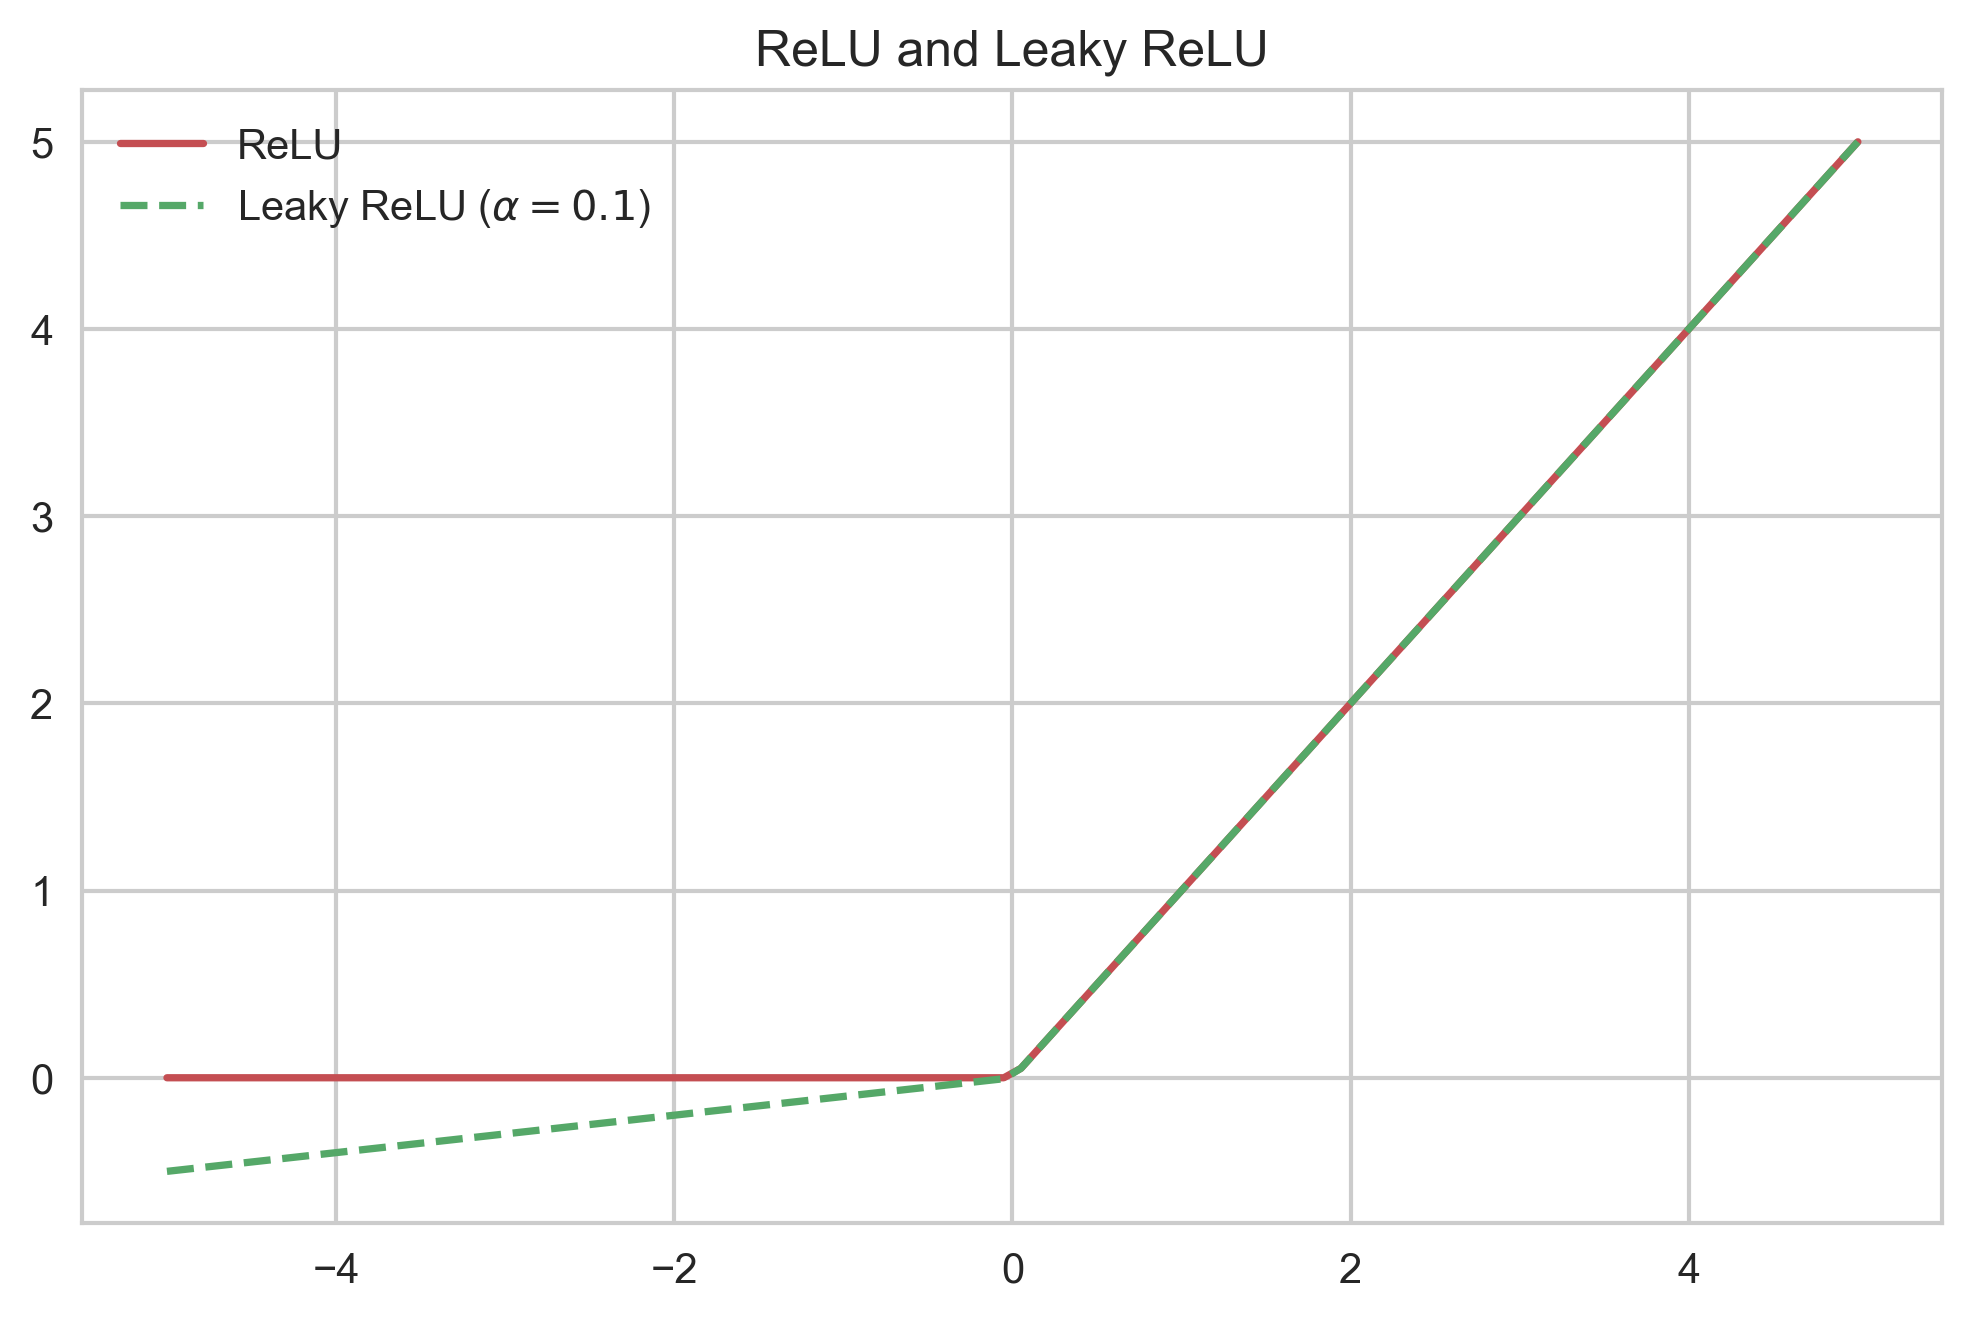

In [5]:
a = np.linspace(-5, 5, 100)
relu = np.maximum(0, a)
leakyrelu = np.maximum(0.1 * a, a)
plt.plot(a, relu, 'r-', label="ReLU")
plt.plot(a, leakyrelu, 'g--', label="Leaky ReLU ($\\alpha=0.1$)")
plt.title("ReLU and Leaky ReLU")
plt.legend()
plt.show()

## 1.5. `keras` - `activation`
* `sigmoid`
* `tanh`
* `relu`

### `activation='sigmoid'`

In [32]:
np.random.seed(0)
model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation="sigmoid"))
model1.add(Dense(10, activation="sigmoid"))
model1.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [33]:
%%time
hist1 = model1.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 13s, sys: 8.86 s, total: 1min 22s
Wall time: 1min 2s


### `activation='tanh'`

In [26]:
np.random.seed(0)
model2 = Sequential()
model2.add(Dense(15, input_dim=784, activation="tanh"))
model2.add(Dense(10, activation="sigmoid"))
model2.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [27]:
%%time
hist2 = model2.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 17s, sys: 9.33 s, total: 1min 27s
Wall time: 1min 4s


### `activation='relu'`

In [28]:
np.random.seed(0)
model3 = Sequential()
model3.add(Dense(15, input_dim=784, activation="relu"))
model3.add(Dense(10, activation="sigmoid"))
model3.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [29]:
%%time
hist3 = model3.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 13s, sys: 8.67 s, total: 1min 21s
Wall time: 58.3 s


### Comparison

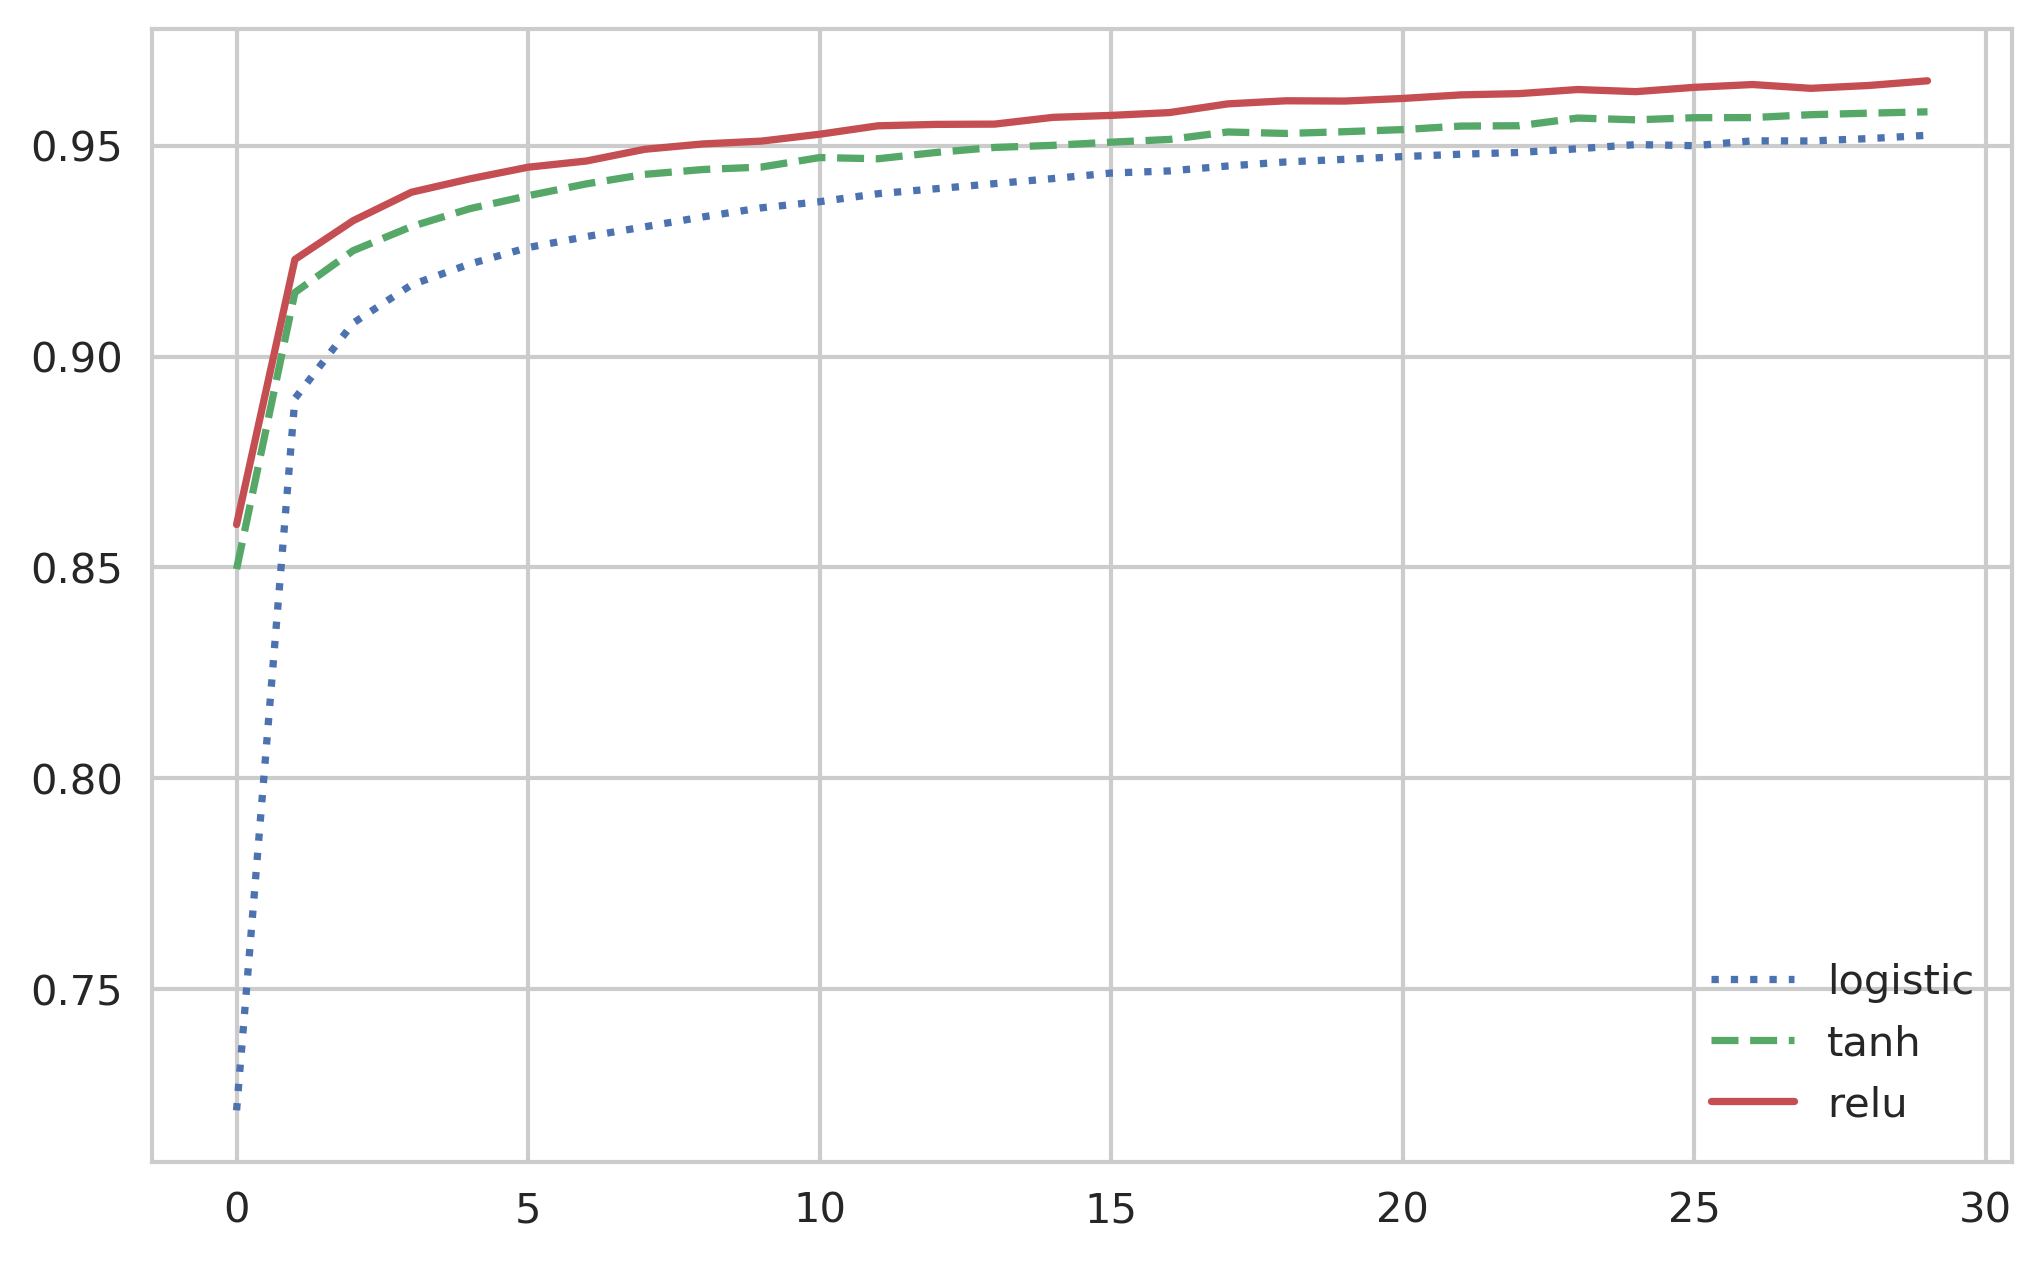

In [34]:
plt.plot(hist1.history['acc'], 'b:', label="logistic")
plt.plot(hist2.history['acc'], 'g--', label="tanh")
plt.plot(hist3.history['acc'], 'r-', label="relu")
plt.legend()
plt.show()

# 2. Cost Function

## 2.1. Cross-Entropy
* Cross-Entropy: offset $\sigma'(a)$

>$$
\begin{eqnarray} 
  C = y \log z^{(L)} + (1-y) \log (1-z^{(L)})
\end{eqnarray}
$$
>$$$$
>$$
\begin{eqnarray}
\frac{\partial C}{\partial w_j^{(L)}} 
&=& \left(\frac{y }{z^{(L)}} - \frac{(1-y)}{1-z^{(L)}} \right) \frac{\partial z^{(L)}}{\partial w_j^{(L)}} \\
&=& \left(\frac{y}{\sigma(a)} - \frac{(1-y)}{1-\sigma(a)} \right)\sigma'(a) z^{(l-1)}_j \\
&=& \frac{\sigma'(a) }{\sigma(a) (1-\sigma(a))} (\sigma(a)-y) z^{(l-1)}_j  \\
&=& (\sigma(a)-y) z^{(l-1)}_j \\ 
&=& (z^{(L)}-y) z^{(l-1)}_j \\ 
\\
\frac{\partial C}{\partial b^{(L)}} &=&  z^{(L)} - y
\end{eqnarray}
$$

## 2.2. `keras` - `loss`
* ``mean_squared_error``
* ``mean_squared_logarithmic_error``
* ``mean_absolute_error``
* ``mean_absolute_percentage_error``
* ``binary_crossentropy``
* ``categorical_crossentropy``

### `loss='mean_squared_error'`

In [15]:
np.random.seed(0)
model0 = Sequential()
model0.add(Dense(15, input_dim=784, activation="sigmoid"))
model0.add(Dense(10, activation="sigmoid"))
model0.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [16]:
%%time
hist0 = model0.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 51.1 s, sys: 5.52 s, total: 56.7 s
Wall time: 46.4 s


### `loss='categorical_crossentropy'`

In [32]:
np.random.seed(0)
model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation="sigmoid"))
model1.add(Dense(10, activation="sigmoid"))
model1.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [33]:
%%time
hist1 = model1.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 13s, sys: 8.86 s, total: 1min 22s
Wall time: 1min 2s


### Comparison

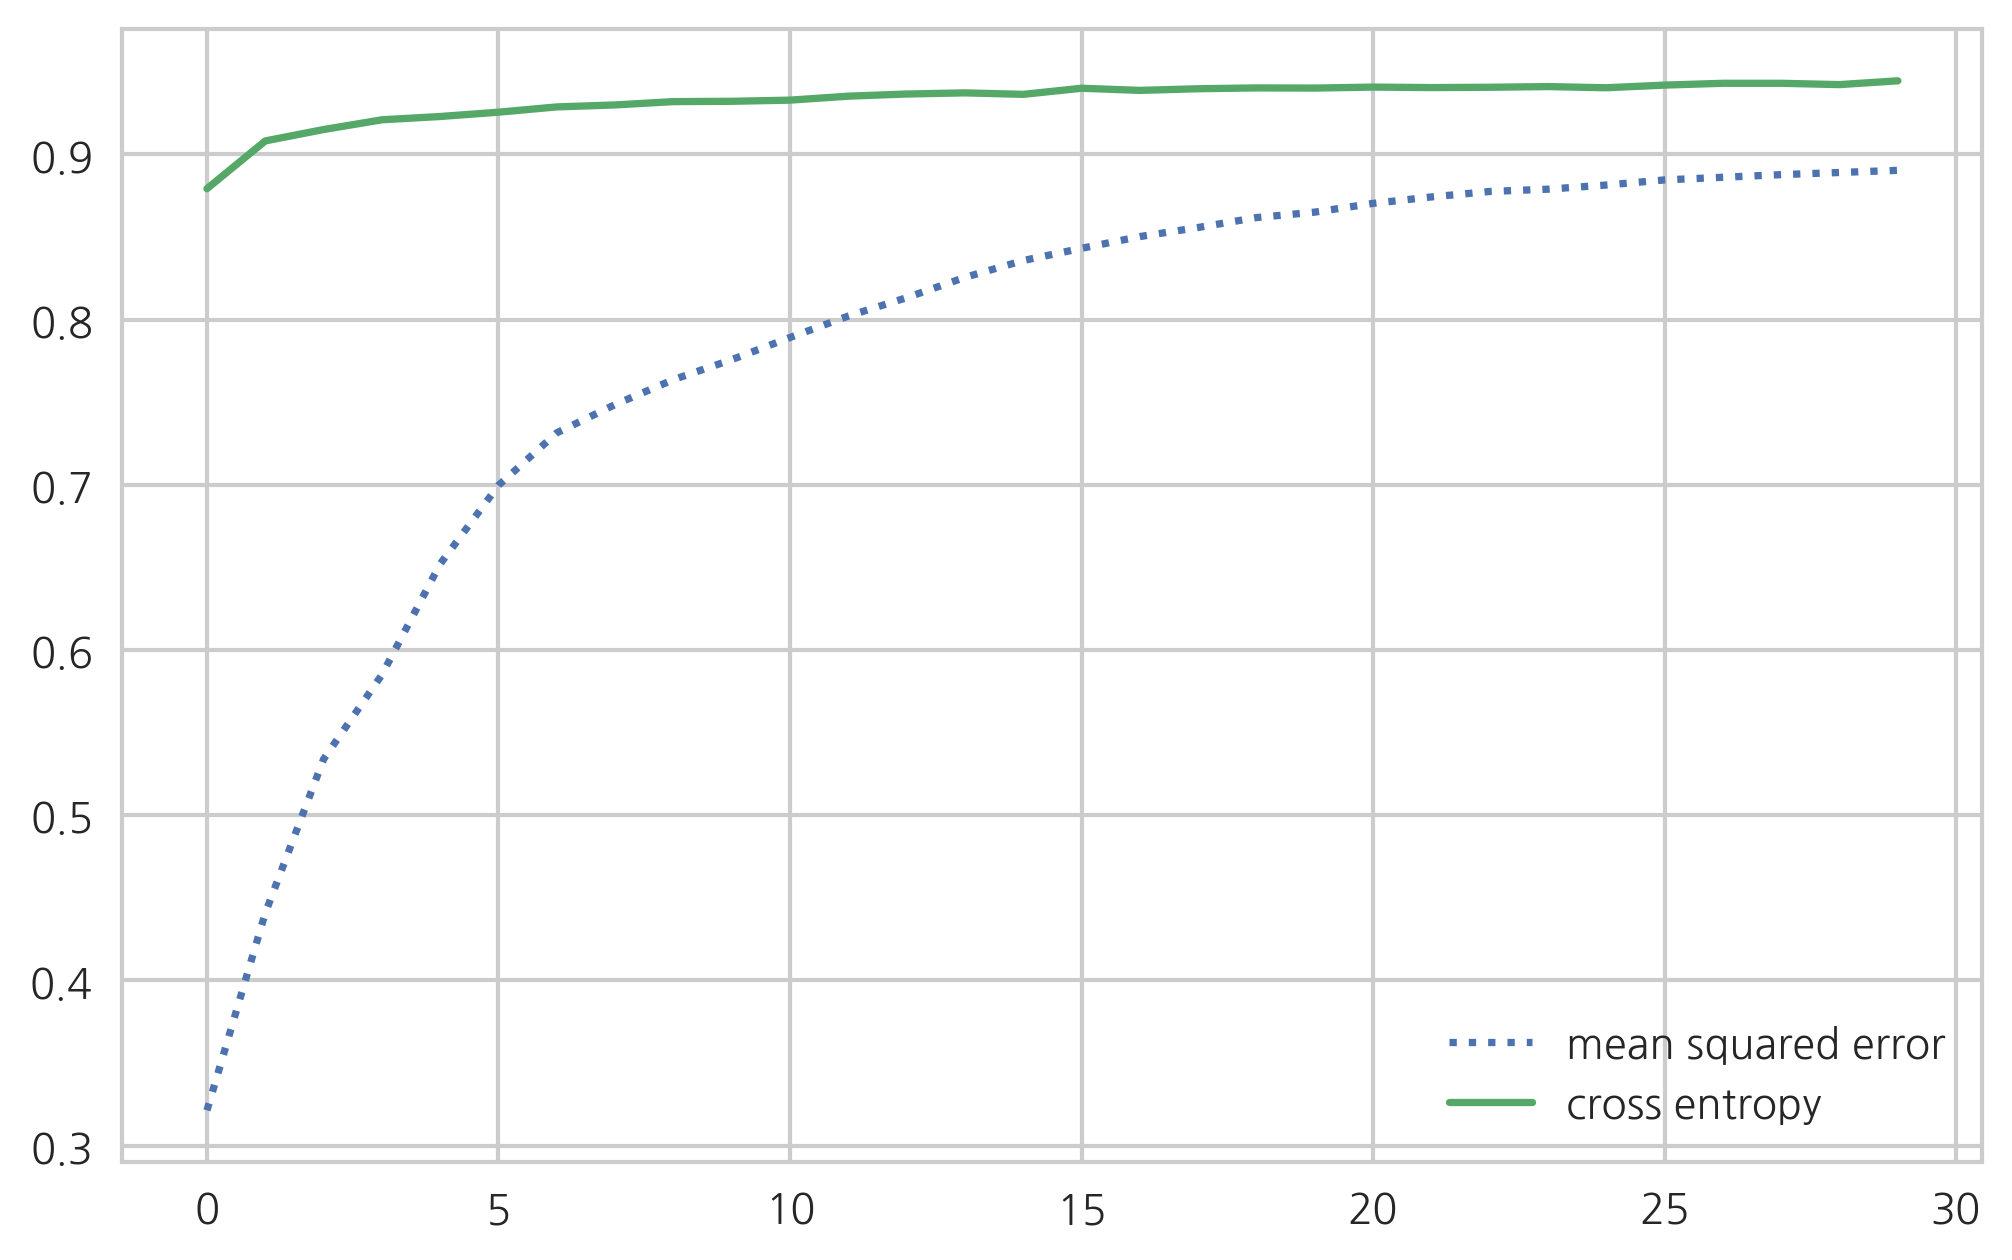

In [11]:
plt.plot(hist0.history['val_acc'], ls=":", label="mean squared error")
plt.plot(hist1.history['val_acc'], label="cross entropy")
plt.legend()
plt.show()

# 3. Weight Initialization
* $n_{\text{in}}$: No. of neurons in input layer
* $n_{\text{out}}$: No. of neurons in output layer

## 3.1. Glorot Initialization

#### Glorot Normal: 

>$$\text{Mean}(W)=0$$
>$$$$
>$$\text{Var}(W)=\dfrac{2}{n_{\text{in}} + n_{\text{out}}}$$

#### Glorot Uniform:

>$$\text{High}(W) = + \sqrt{\dfrac{6}{(n_{\text{in}} + n_{\text{out}})}}$$
>$$$$
>$$\text{Low}(W) = - \sqrt{\dfrac{6}{(n_{\text{in}} + n_{\text{out}})}}$$

## 3.2. LeCun Initialization

#### LeCun Normal: 

>$$\text{Mean}(W)=0$$
>$$$$
>$$\text{Var}(W)=\dfrac{1}{n_{\text{in}}}$$

#### LeCun Uniform:

>$$\text{High}(W) = + \sqrt{\dfrac{3}{n_{\text{in}}}}$$
>$$$$
>$$\text{Low}(W) = - \sqrt{\dfrac{3}{n_{\text{in}}}}$$

## 3.3. `keras` - `kernel_initializer`
* `random_uniform`
* `random_normal`
* `glorot_uniform`
* `glorot_normal`
* `lecun_uniform`
* `lecun_normal`

### `kernel_initializer='normal'`

In [115]:
np.random.seed(0)
model4 = Sequential()
model4.add(Dense(100, kernel_initializer="normal", activation="sigmoid", input_dim=784))
model4.add(Dense(10, kernel_initializer="normal", activation="sigmoid"))
model4.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [116]:
%%time
hist4 = model4.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 5min 27s, sys: 30.4 s, total: 5min 57s
Wall time: 2min 44s


### `kernel_initializer='glorot_uniform'`

In [117]:
np.random.seed(0)
model5 = Sequential()
model5.add(Dense(100, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.add(Dense(10, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [118]:
%%time
hist5 = model5.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 5min 28s, sys: 30.1 s, total: 5min 58s
Wall time: 2min 45s


### Comparison

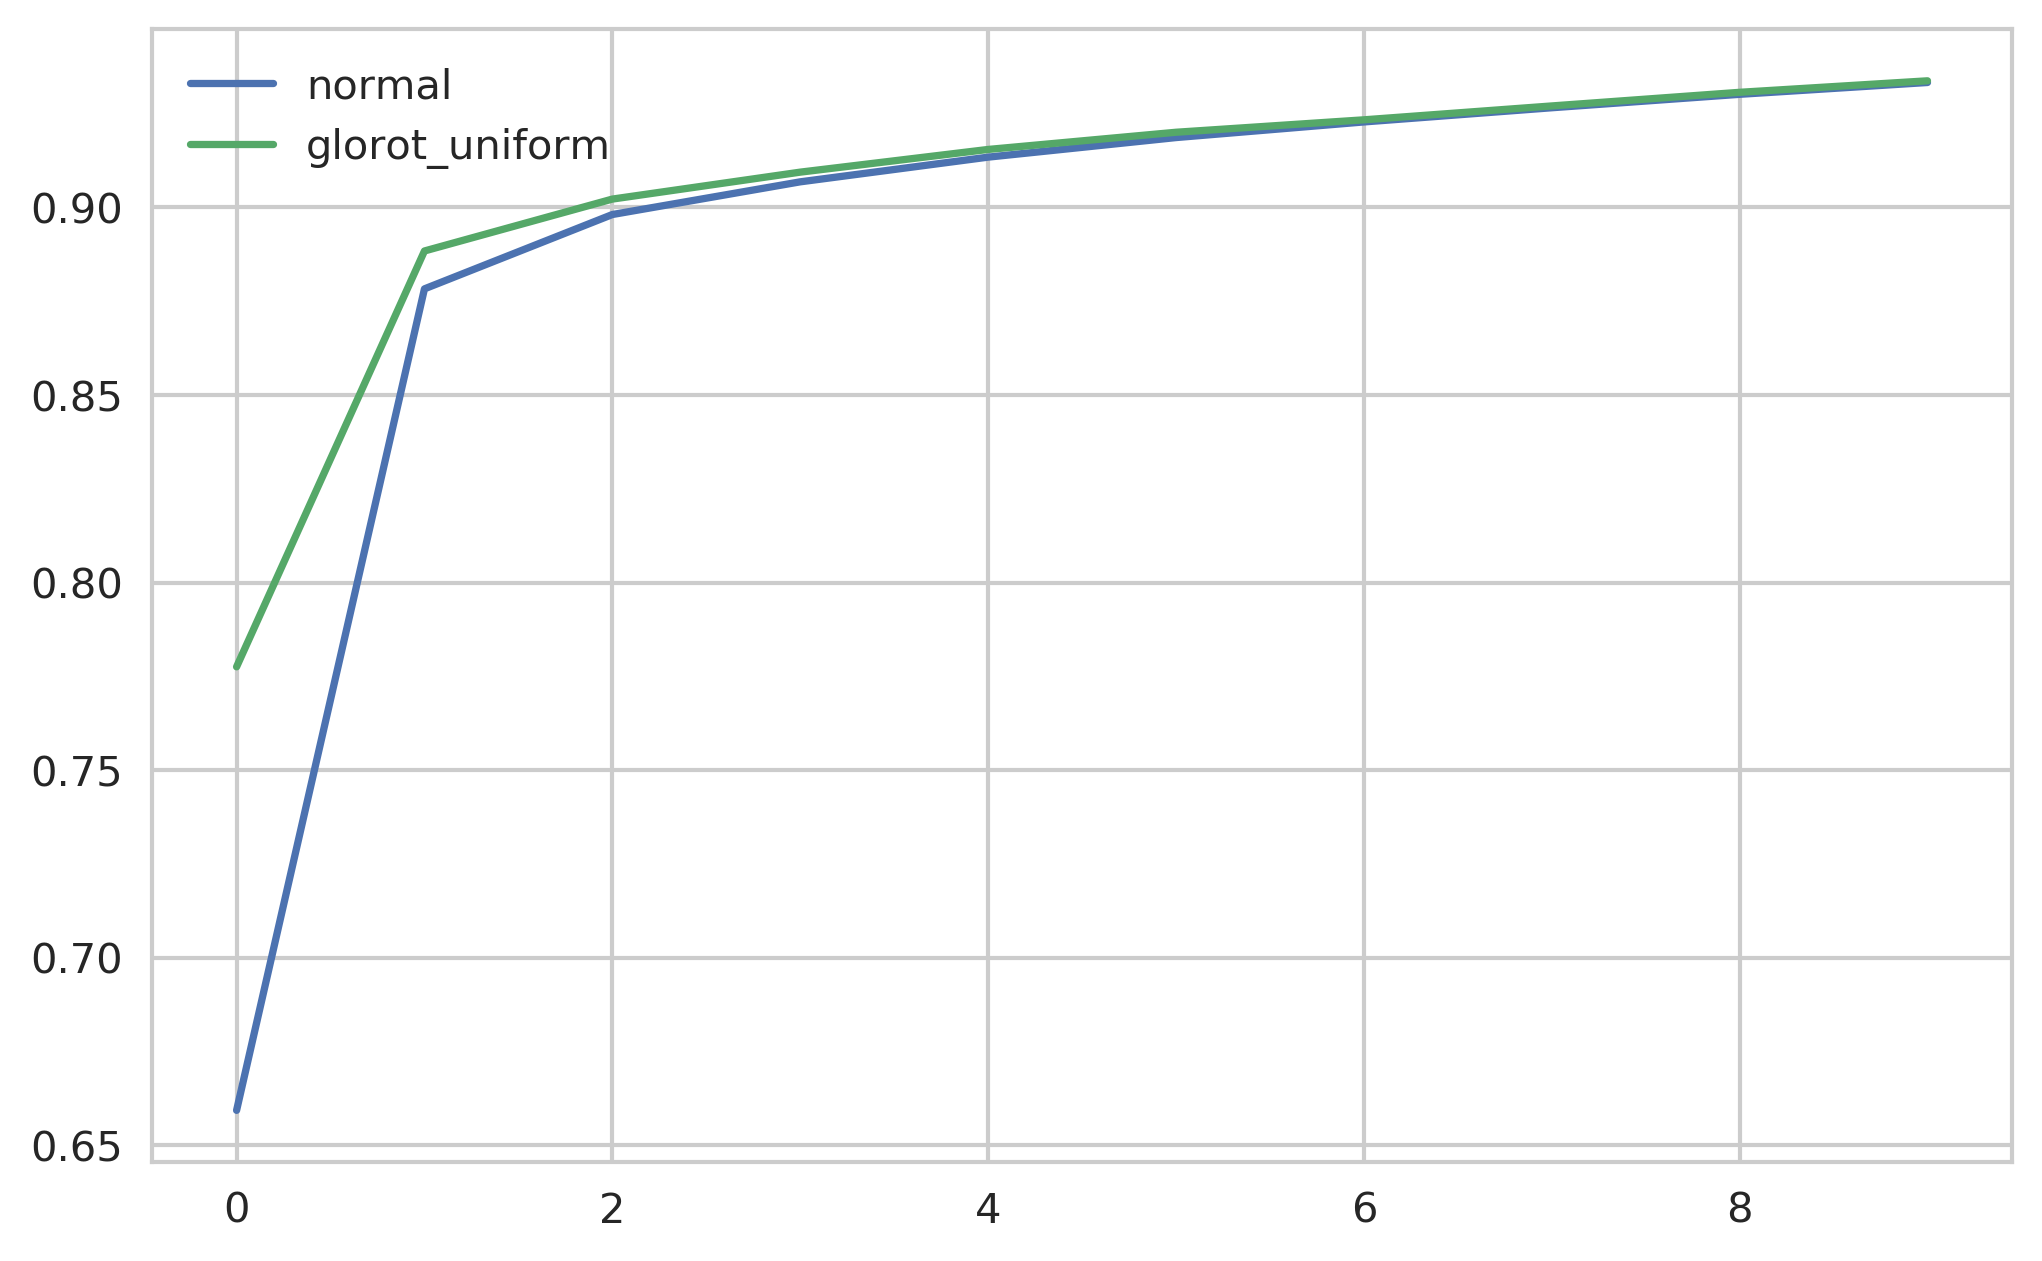

In [119]:
plt.plot(hist4.history['acc'], label="normal")
plt.plot(hist5.history['acc'], label="glorot_uniform")
plt.legend()
plt.show()

# 4. Optimization Alorithm
* [Reference](http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html)

## 4.1. Gradient Descent (default)

>$$ w_{k+1} = w_k - \mu_k g(w_k) = w_k - v_k $$

## 4.2. Decay
* Reduce step-size

>$$ \mu_{k+1} = \mu_{k} \dfrac{1}{1 + \text{decay}} $$

## 4.3. Momentum
* Inertia (tries to move towards its original direction)

>$$ v_{k+1} = \text{momentum} \cdot v_k - \mu_k g(w_k) $$


## 4.4. Nesterov Momentum
* Move along momentum & Then use gradient

>$$ v_{k+1} = \text{momentum} \cdot v_k - \mu_k g(w_k - \text{momentum} \cdot v_k) $$

## 4.5. Adagrad
* Adaptive Gradient

>$$ G_{k+1} = G_k + g^2 $$
>
>$$ w_{k+1} = w_k - \dfrac{\mu_k}{\sqrt{G_k + \epsilon}} g(w_k) $$

## 4.6. RMSProp

>$$ G_{k+1} = \gamma G_k + (1 - \gamma) g^2 $$
>
>$$ w_{k+1} = w_k - \dfrac{\mu_k}{\sqrt{G_k + \epsilon}} g(w_k) $$

## 4.7. AdaDelta

>$$ G_{k+1} = \gamma G_k + (1 - \gamma) g^2 $$
>
>$$ \mu_{k+1} = \gamma \mu_k + (1 - \gamma) \Delta_k^2 $$
>
>$$ \Delta_k = \dfrac{\sqrt{\mu_k + \epsilon}}{\sqrt{G_k + \epsilon}} g(w_k) $$
>
>$$ w_{k+1} = w_k - \Delta_k $$

## 4.8. Adam
* Adaptive Momentum

>$$ G_{k+1} = \gamma G_k + (1 - \gamma) g^2 $$
>
>$$ v_{k+1} = \gamma_v v_k + (1 - \gamma_v) g_k^2 $$
>
>$$ \hat{G}_k = \dfrac{G_k}{1 - \beta_1} $$
>
>$$ \hat{v}_k = \dfrac{v_k}{1 - \beta_2} $$
>
>$$ w_{k+1} = w_k - \dfrac{\mu_k}{\sqrt{\hat{G}_k + \epsilon}} \hat{v}_k $$

# 5. Regularization

## 5.1. Overfitting

In [120]:
np.random.seed(0)
model6 = Sequential()
model6.add(Dense(30, input_dim=784, activation="sigmoid"))
model6.add(Dense(10, activation="sigmoid"))
model6.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [121]:
%%time
hist6 = model6.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 17min 32s, sys: 1min 32s, total: 19min 5s
Wall time: 8min 49s


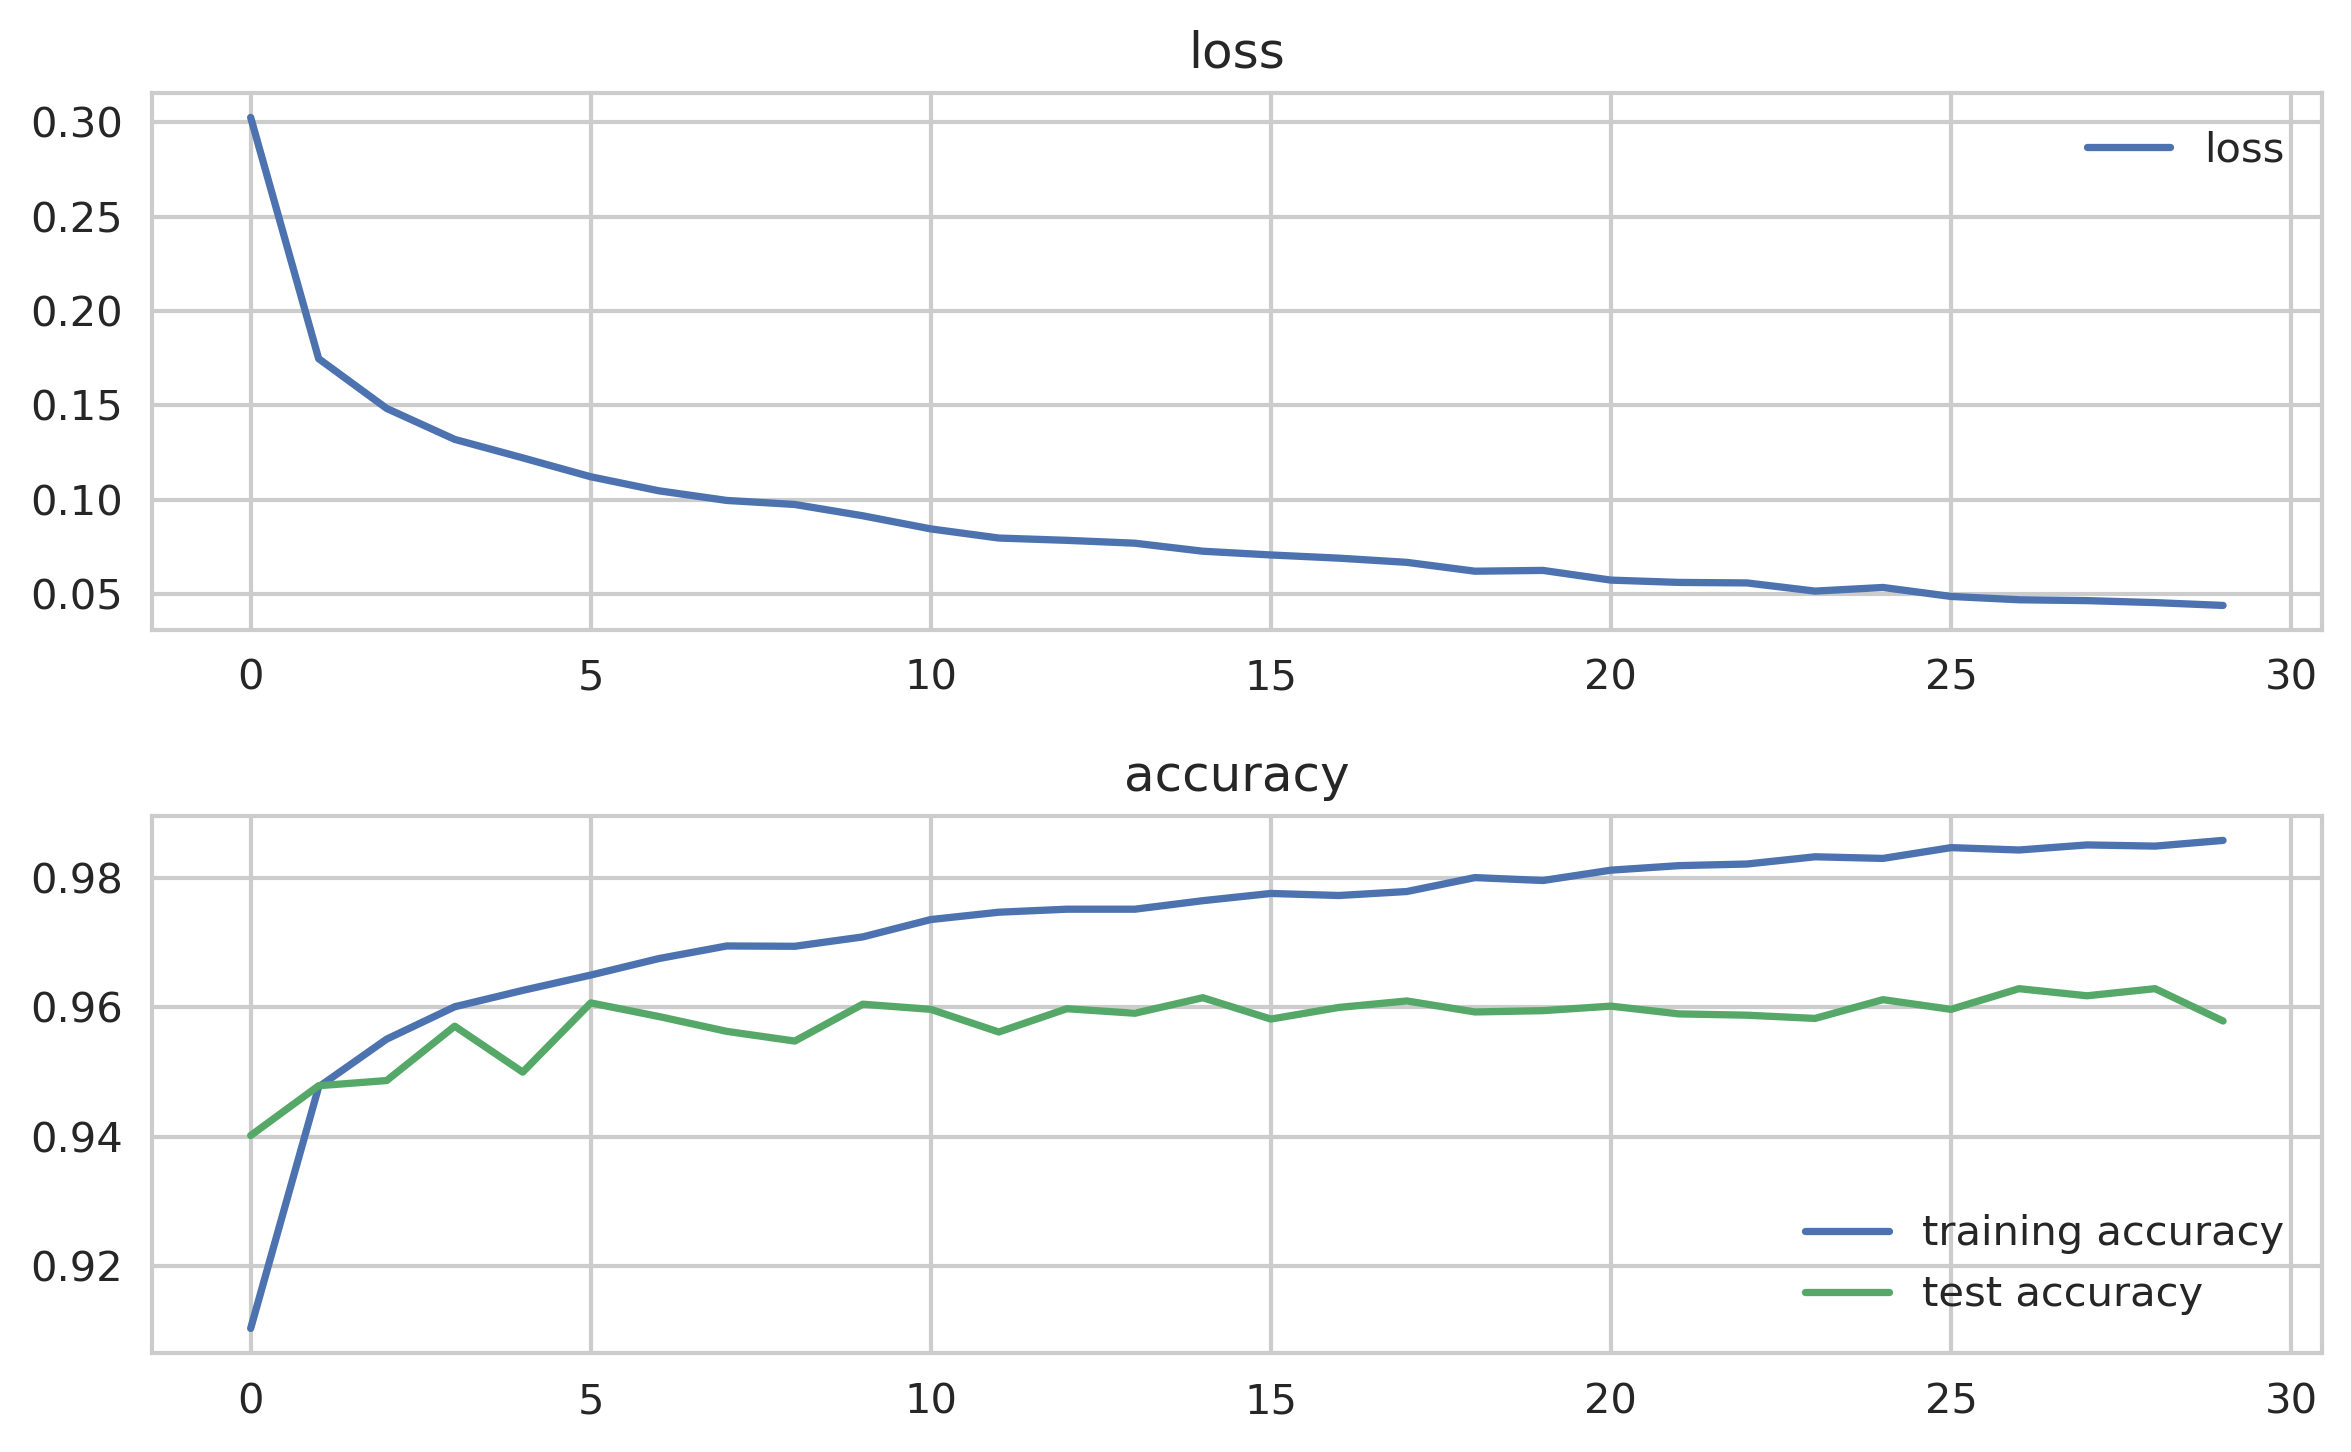

In [122]:
plt.subplot(211)
plt.plot(hist6.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist6.history['acc'], label="training accuracy")
plt.plot(hist6.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## 5.2. L1 & L2 Regularization

#### L1 Regularization

>$$
C = - (y \log z+(1-y) \log(1-z)) + \lambda \sum_i |w_i|
$$

#### L2 Regularization

>$$
C = - (y \log z+(1-y) \log(1-z)) + \lambda \sum_i w_i^2
$$

## 5.3. `keras` - `kernel_regularizer`

In [14]:
from keras import regularizers

np.random.seed(0)
model7 = Sequential()
model7.add(Dense(30, input_dim=784, activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model7.add(Dense(10, activation="sigmoid"))
model7.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [15]:
%%time
hist7 = model7.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 18min 24s, sys: 1min 47s, total: 20min 11s
Wall time: 8min 58s


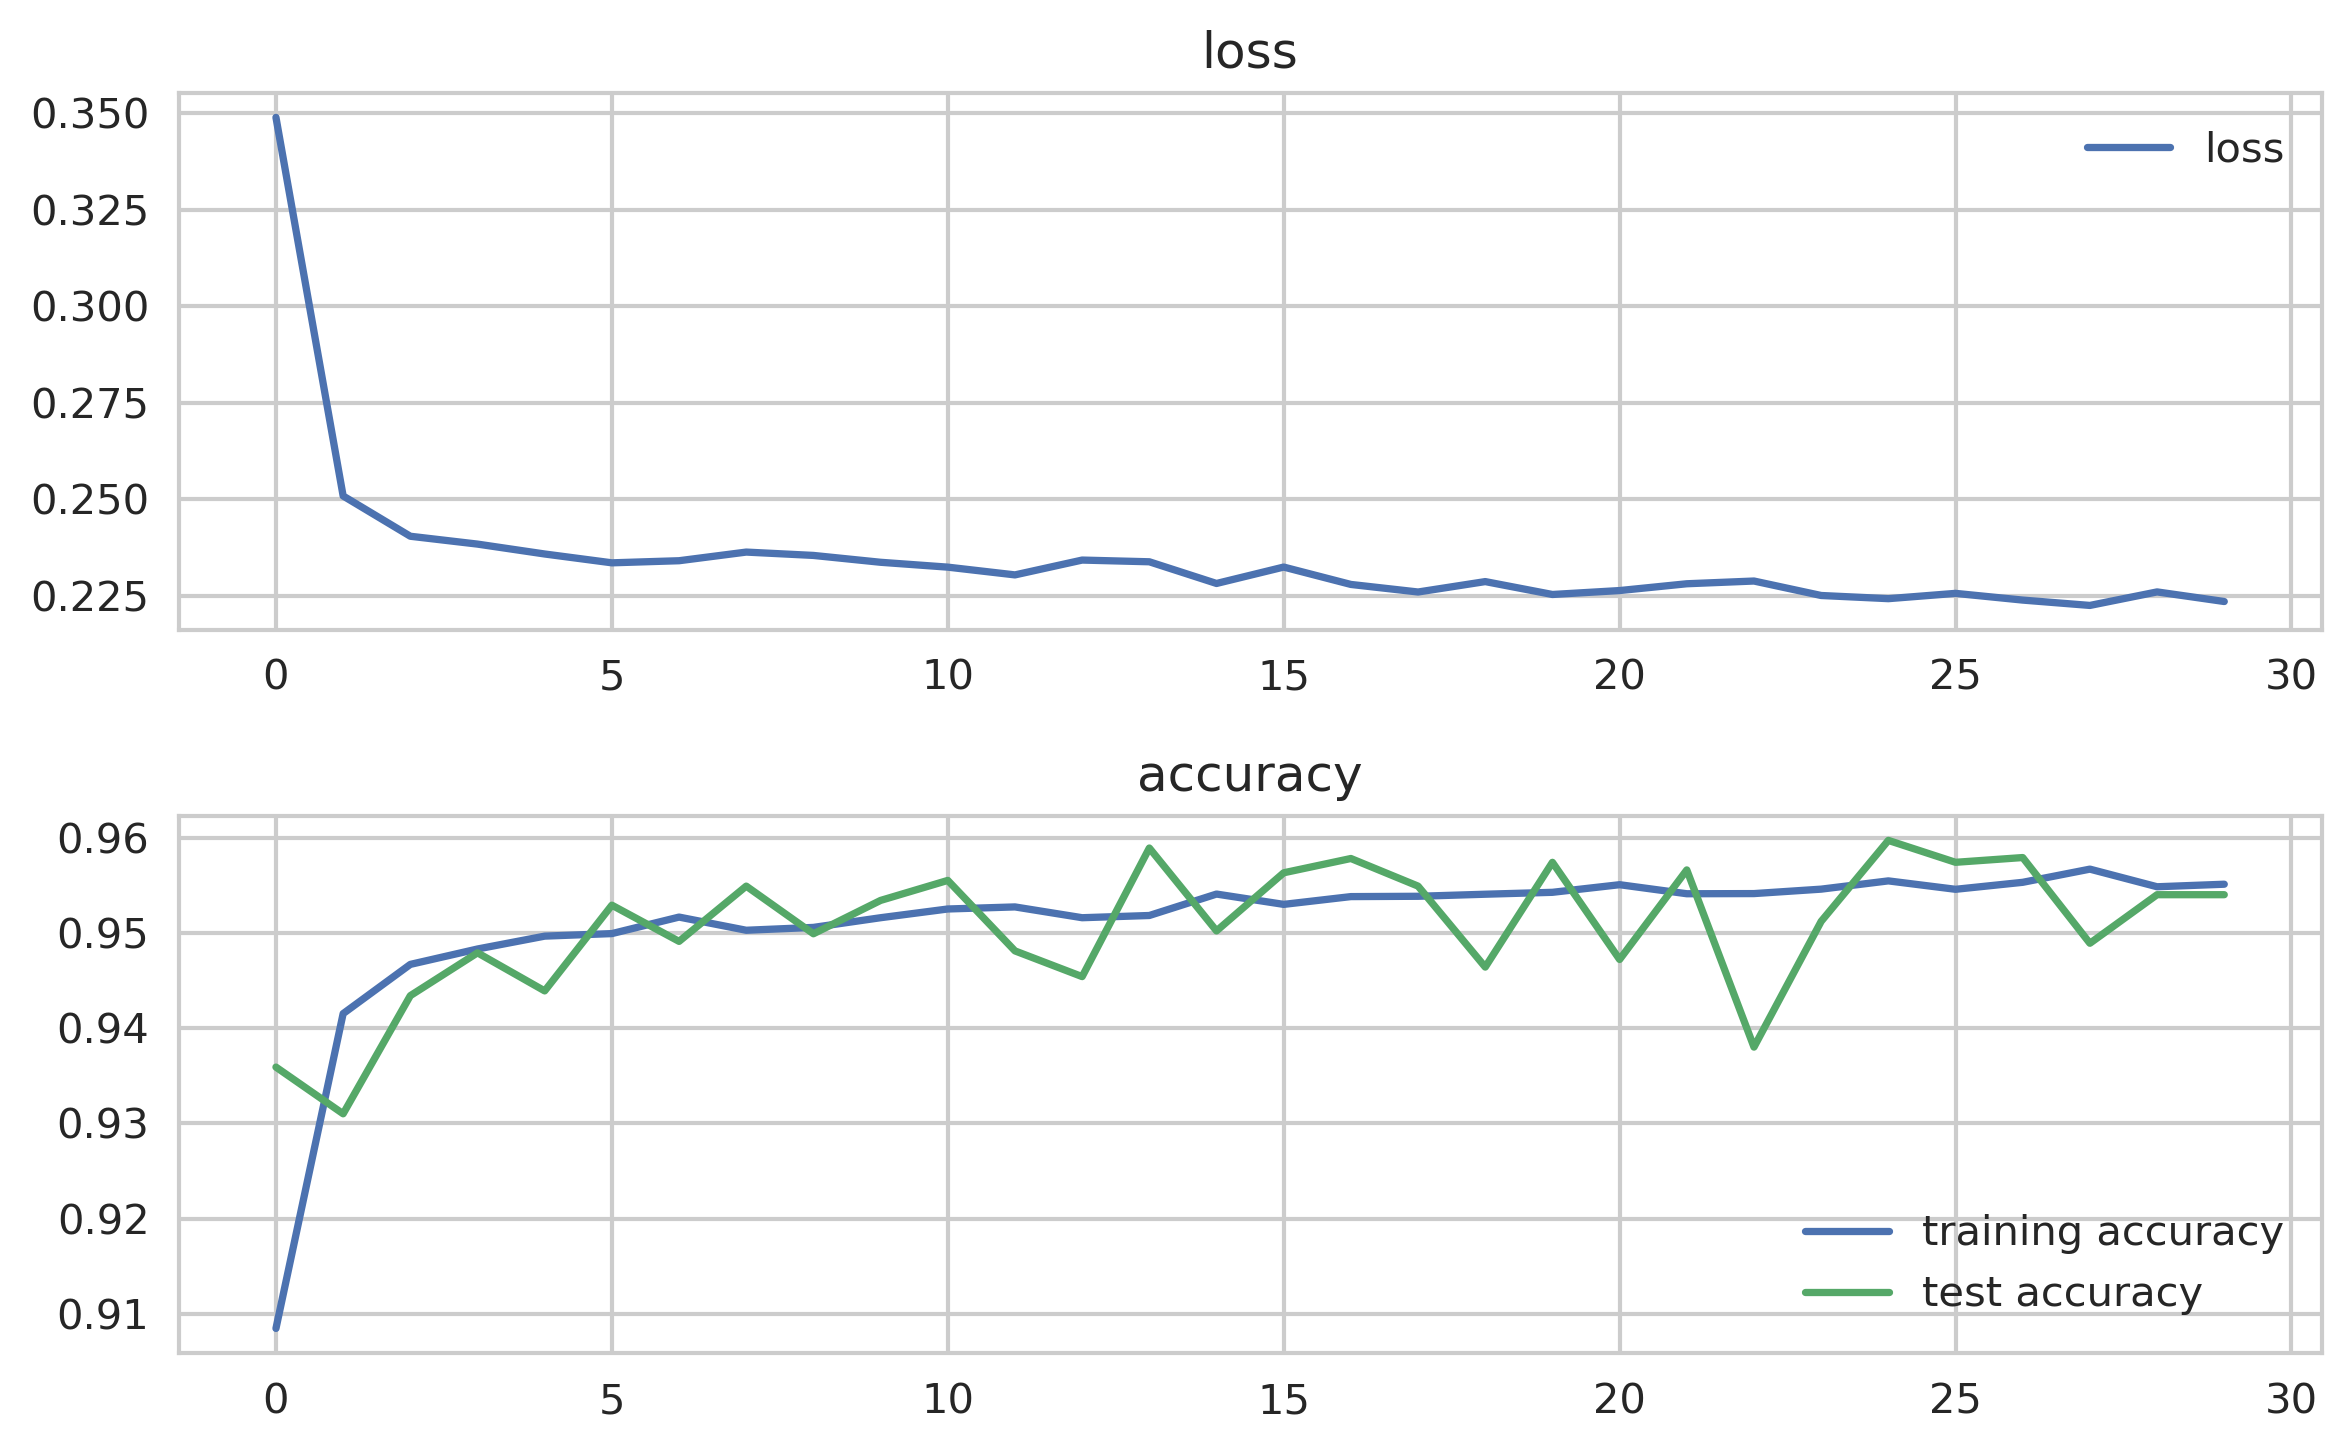

In [16]:
plt.subplot(211)
plt.plot(hist7.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist7.history['acc'], label="training accuracy")
plt.plot(hist7.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## 5.4. Dropout Regularization
* For each epoch drop $100 \times p %$ of hidden layer neurons
* Helps prevent overfitting

<img src="http://neuralnetworksanddeeplearning.com/images/tikz31.png">

## 5.5. `keras` - `Dropout`

In [17]:
from keras.layers import Dropout

np.random.seed(0)
model8 = Sequential()
model8.add(Dense(30, input_dim=784, activation="sigmoid"))
model8.add(Dropout(0.1))
model8.add(Dense(10, activation="sigmoid"))
model8.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [18]:
%%time
hist8 = model8.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 17min 54s, sys: 1min 31s, total: 19min 25s
Wall time: 9min 3s


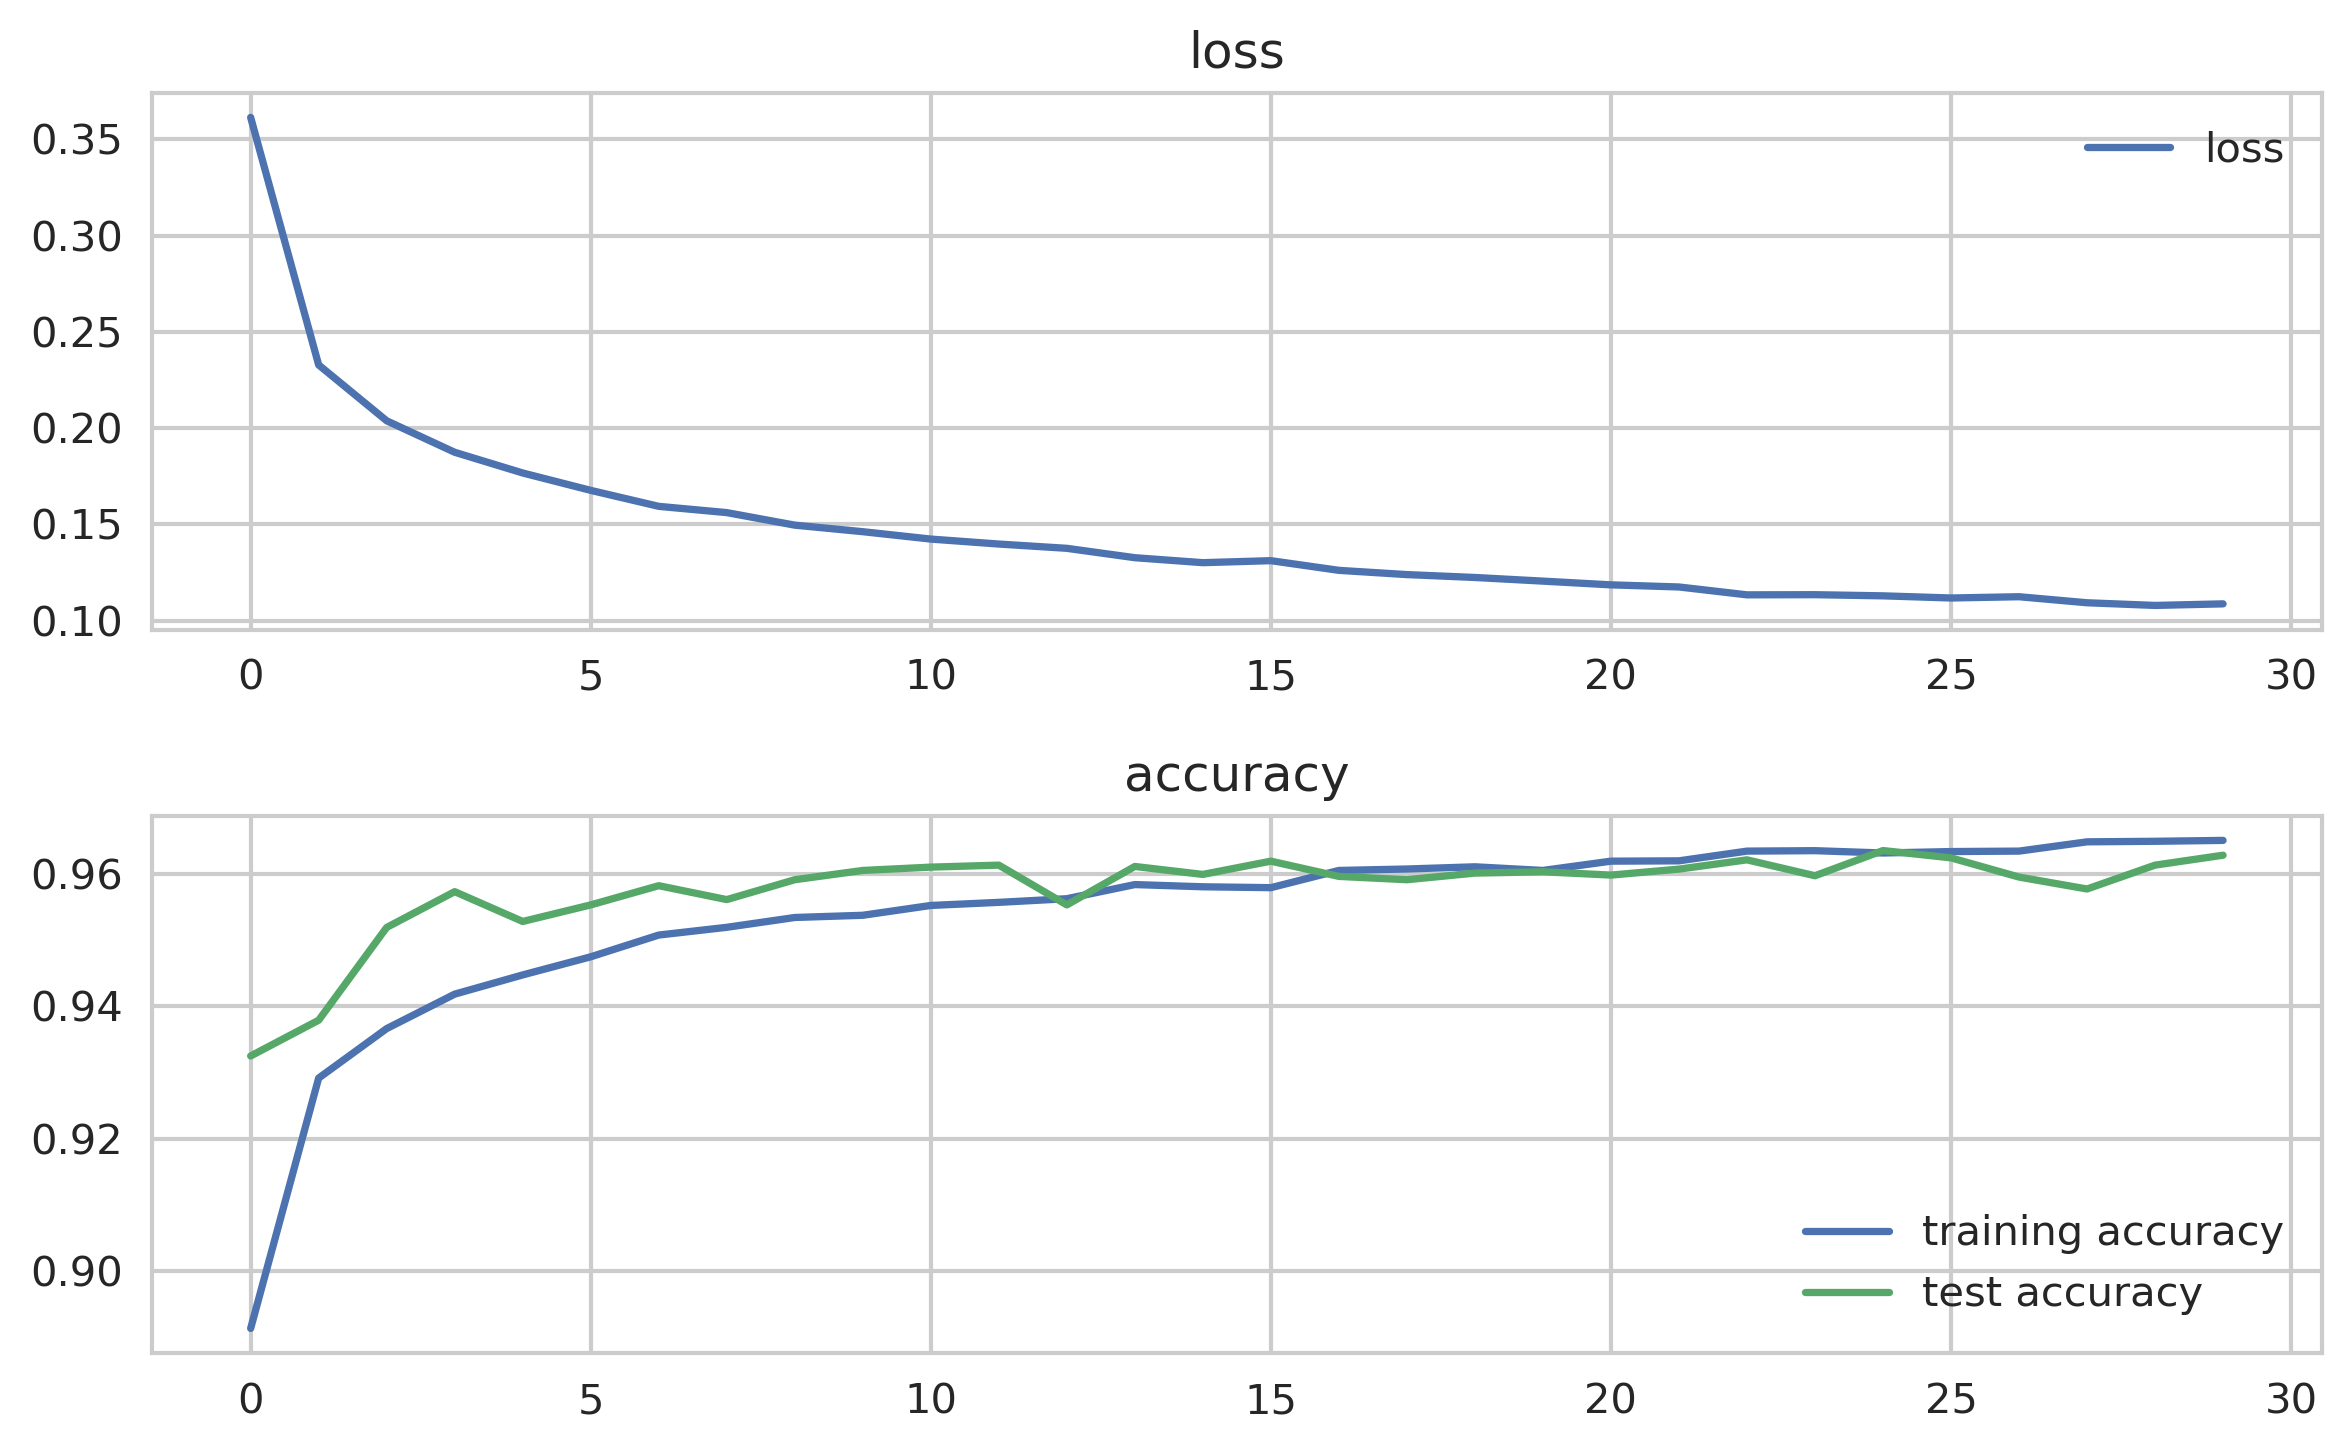

In [19]:
plt.subplot(211)
plt.plot(hist8.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist8.history['acc'], label="training accuracy")
plt.plot(hist8.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

# 6. Softmax
* Softmax fn. $\rightarrow$ $\text{sum of output} = 1$
* Then, the output values can be interpreted as probability mass

>$$
\begin{eqnarray} 
  y^L_j = \frac{e^{a^L_j}}{\sum_k e^{a^L_k}},
\end{eqnarray}
$$
>
>$$
\begin{eqnarray}
  \sum_j y^L_j & = & \frac{\sum_j e^{a^L_j}}{\sum_k e^{a^L_k}} = 1
\end{eqnarray}
$$

><img src="https://www.tensorflow.org/versions/master/images/softmax-regression-scalargraph.png" style="width:60%;">



## 6.1. `keras` - `activation='softmax'`

In [21]:
np.random.seed(0)
model9 = Sequential()
model9.add(Dense(15, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model9.add(Dense(10, activation="softmax", kernel_initializer="glorot_uniform"))
model9.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [22]:
%%time
hist9 = model9.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 5min 28s, sys: 29.4 s, total: 5min 57s
Wall time: 2min 42s


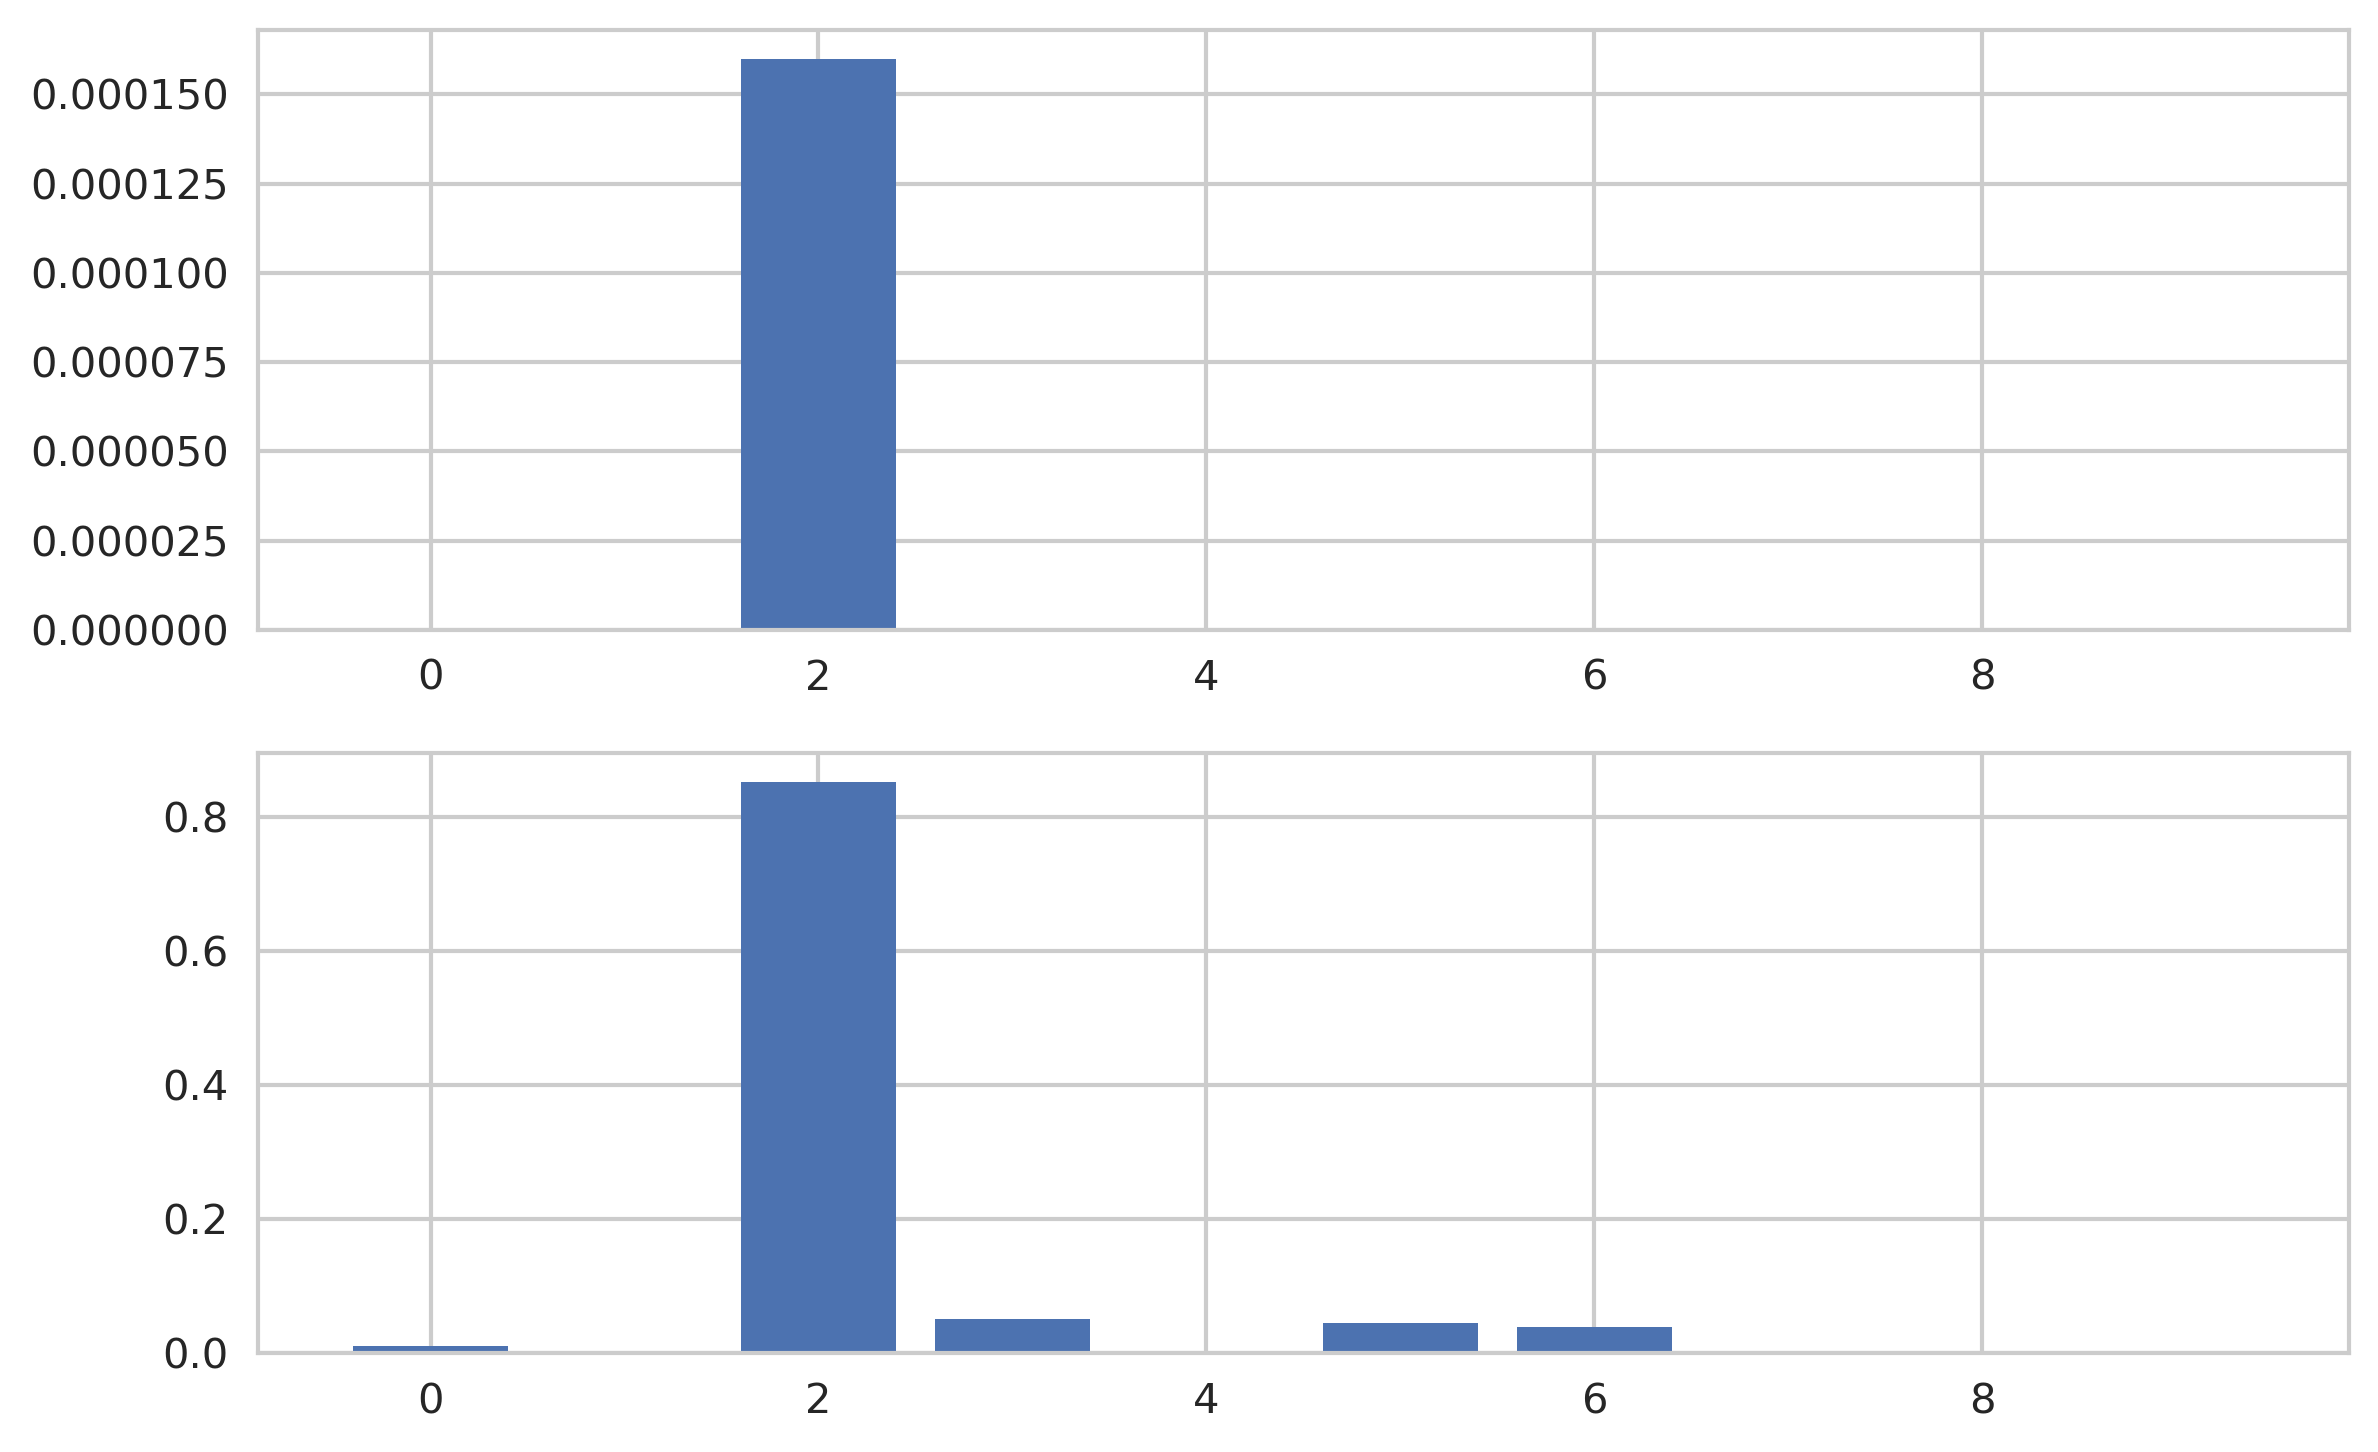

In [23]:
k = 1
y8 = model8.predict(X_test[k:k+1, :])[0]
y9 = model9.predict(X_test[k:k+1, :])[0]

plt.subplot(211)
plt.bar(range(len(y8)), y8, align="center")
plt.subplot(212)
plt.bar(range(len(y9)), y9, align="center")
plt.tight_layout()
plt.show()

# 7. Batch Normalization
* After each mini-batch, scale $a$ to make $\text{Mean}(a)=0, \text{Var}(a)=1$

<img src="https://i0.wp.com/mohammadpz.github.io/posts/2015_02_01_IFT6266_Cats_vs_Dogs/img/bn.png?zoom=2">

## 7.1. `keras` - `BatchNormalizaiton`

In [19]:
from keras.layers import Activation, BatchNormalization

np.random.seed(0)
model10 = Sequential()
model10.add(Dense(15, input_dim=784))
model10.add(BatchNormalization())
model10.add(Activation('sigmoid'))
model10.add(Dense(10))
model10.add(BatchNormalization())
model10.add(Activation('sigmoid'))
model10.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [20]:
%%time
hist10 = model10.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 24s, sys: 10.6 s, total: 1min 35s
Wall time: 1min 8s


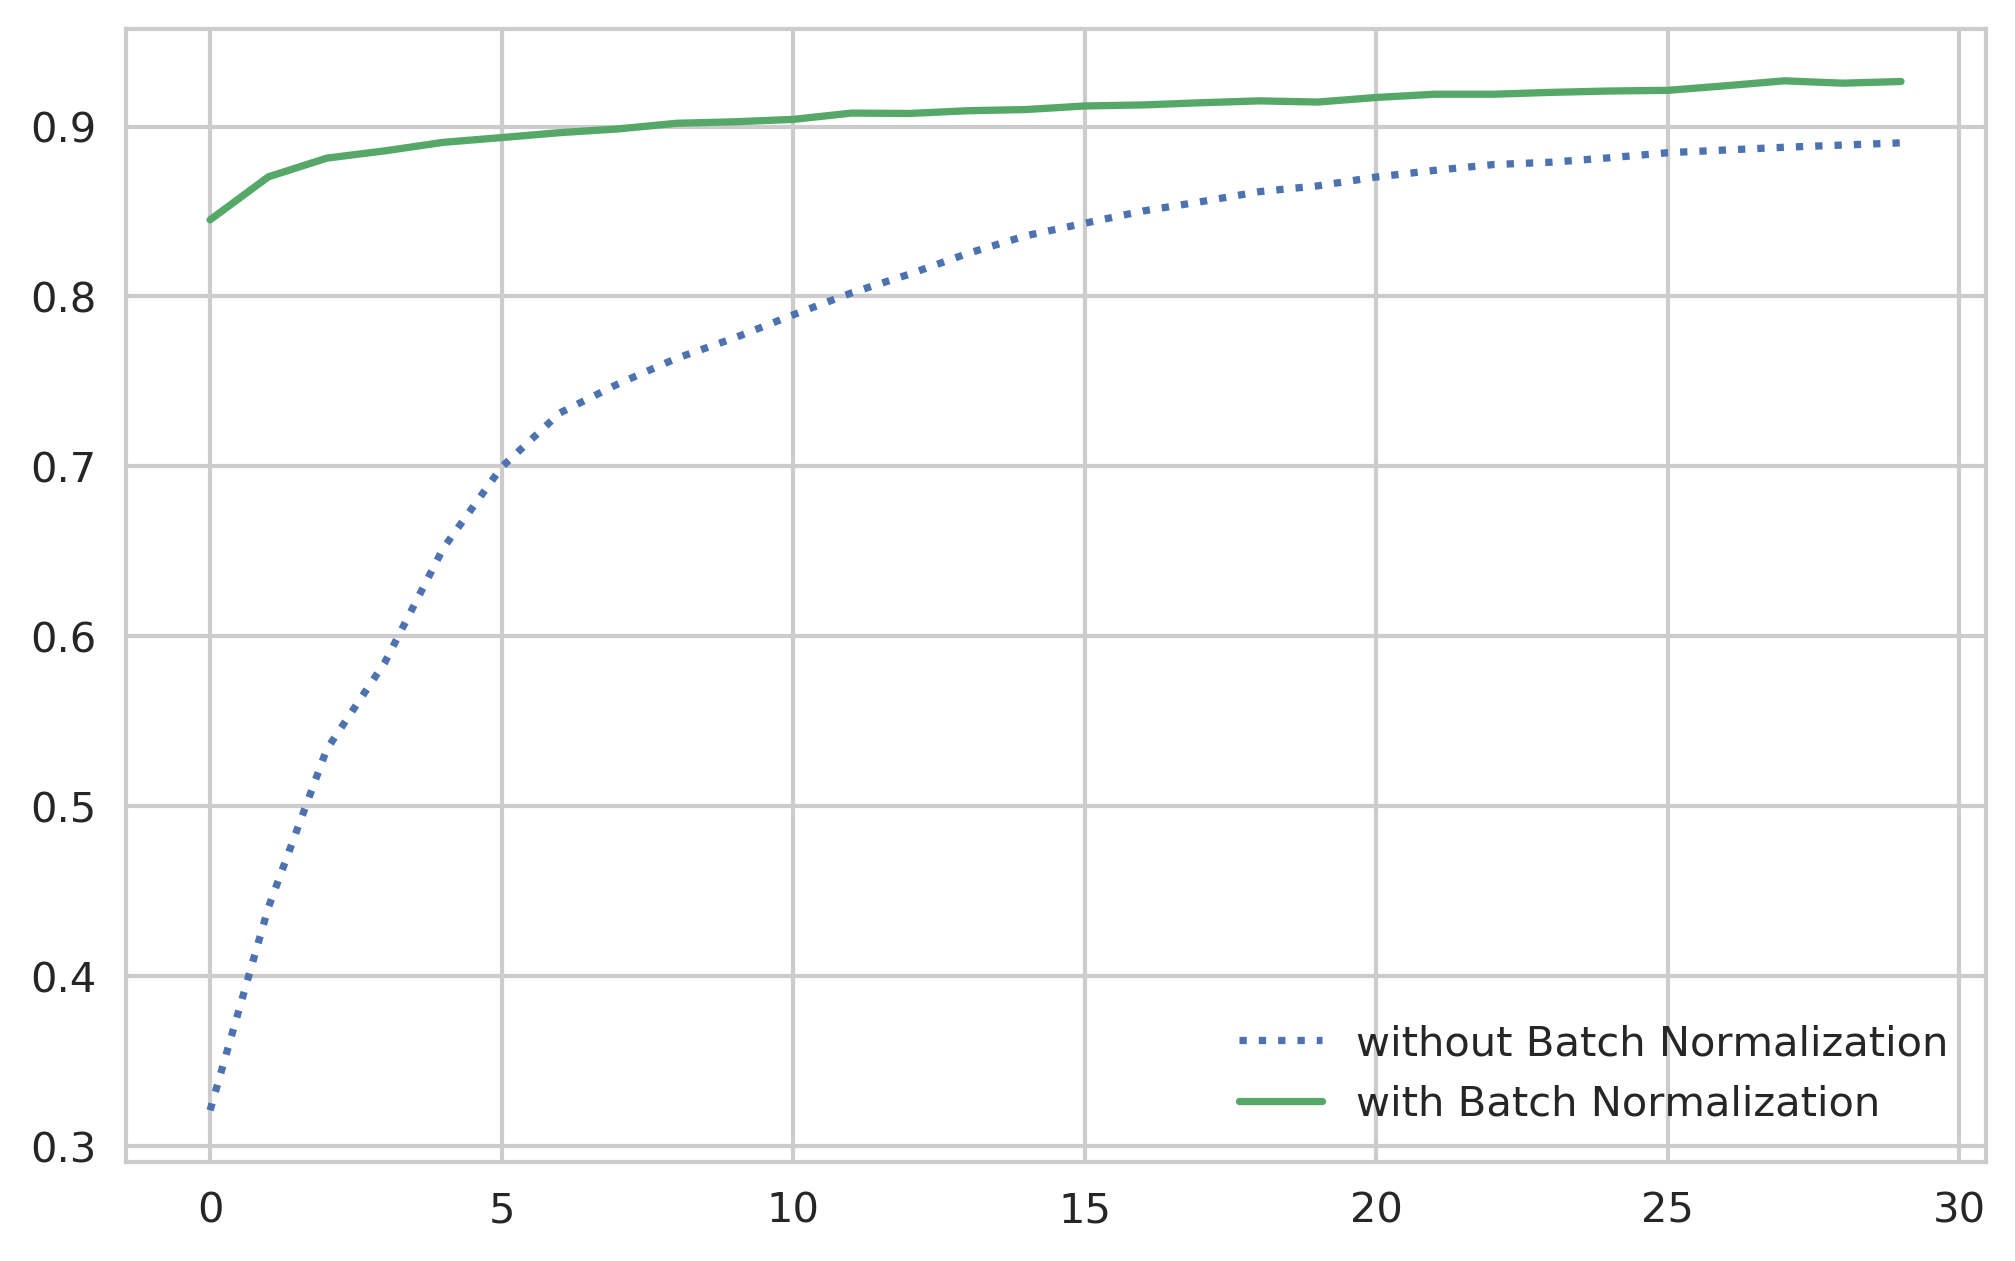

In [21]:
plt.plot(hist0.history['val_acc'], ls=":", label="without Batch Normalization")
plt.plot(hist10.history['val_acc'], label="with Batch Normalization")
plt.legend()
plt.show()